In [2]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime as dt
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [3]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [4]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [6]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3','forpr_haro3','forgulf_haro3','backvs_haro3','backadm_haro3',
         'forvs_haro3','foradm_haro3','backpr_haro3','backgulf_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2019,12,28)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        else:
            print(name,'missing')
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


/ocean/cstang/MOAD/analysis-camryn/Ariane/forvs_haro3/30apr19_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/30dec18_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/31dec18_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/01jan19_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/02jan19_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/03jan19_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/04jan19_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/05jan19_s1t50/ariane_positions_quantitative.nc missing
/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_haro3/06jan19_s1t50/ariane_positions_quantitative.nc missing
/ocean/csta

In [7]:
dict_secdata = {}
sectionnum = [0,1,2,3,4,5,6,7,8]

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            if section not in dict_secdata[file]:
            
                dict_secdata[file][section][date] = {}
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)

In [8]:
dict_secdata['foradm_haro3'][0]['01jan18']['final_salt']

<xarray.DataArray 'final_salt' (ntraj: 11369)>
[11369 values with dtype=float32]
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_salt ?
    longname:  Final salinity
    units:     psu

In [9]:
month_avg = np.zeros([12,len(sectransp_2018['forpr_ros3'].keys())])

for sectionnum in sectransp_2018['forpr_ros3'].keys():
    intermed = sectransp_2018['forpr_ros3'][sectionnum]
    for month in range(1,13):
        dates = [index for index, date in enumerate(datelist_vs) if date.month == month]
        selected_elements = [sectransp_2018['forpr_ros3'][sectionnum][index] for index in dates]
        month_avg[month-1,sectionnum] = np.mean(selected_elements)
    

In [10]:
dates = [index for index, date in enumerate(datelist_vs) if date.month == 1]
selected_elements = [sectransp_2018['forpr_ros3'][0][index] for index in dates]
date_jan = [datelist_vs for index in dates]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2019,1,1)

dates = []
datelist_yr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yr.append(date)
    date+=dt.timedelta(days=31)

In [11]:
datelist_yr

[datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 2, 1, 0, 0),
 datetime.datetime(2018, 3, 4, 0, 0),
 datetime.datetime(2018, 4, 4, 0, 0),
 datetime.datetime(2018, 5, 5, 0, 0),
 datetime.datetime(2018, 6, 5, 0, 0),
 datetime.datetime(2018, 7, 6, 0, 0),
 datetime.datetime(2018, 8, 6, 0, 0),
 datetime.datetime(2018, 9, 6, 0, 0),
 datetime.datetime(2018, 10, 7, 0, 0),
 datetime.datetime(2018, 11, 7, 0, 0),
 datetime.datetime(2018, 12, 8, 0, 0)]

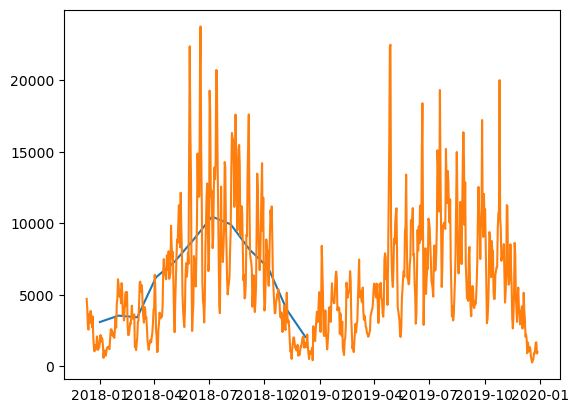

In [12]:
plt.plot(datelist_yr,month_avg[:,4])
plt.plot(datelist_vs,sectransp_2018['forpr_ros3'][4])

### Shifting functions

In [13]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [14]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2017-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

density_rosVS = pd.read_csv('sigma_2018_rosariopr_202111_meanv2.csv')
dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = np.array(density_haro.south - density_haro.north)

density_vspr = pd.read_csv('../notebooks/sigma_2017-22_202111_mean.csv')
dens_diff_vspr = np.array(density_vspr.south - density_vspr.north)

tides = pd.read_csv('../notebooks/low_pass_tide_2018-22_BP.csv')
# tides = pd.read_csv('low_pass_tide_18-22.csv').iloc[:730,:]


date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens))
print(dens_diff_vspr.size)

2191
(2191,)
2191
2191


In [15]:
wind = pd.read_csv('../notebooks/day_avg_wind_17-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

#### Rosario to adm

In [16]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [17]:
PRtoadm_rosb

2017-12-10     820.595292
2017-12-11    1149.001901
2017-12-12     749.904988
2017-12-13     707.988881
2017-12-14     889.198318
                 ...     
2019-12-24     948.670832
2019-12-25    1184.997729
2019-12-26    1313.034845
2019-12-27    1028.737754
2019-12-28     427.219285
Length: 749, dtype: float64

In [18]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])

In [19]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.8] [0.4]


0.6065886041505925


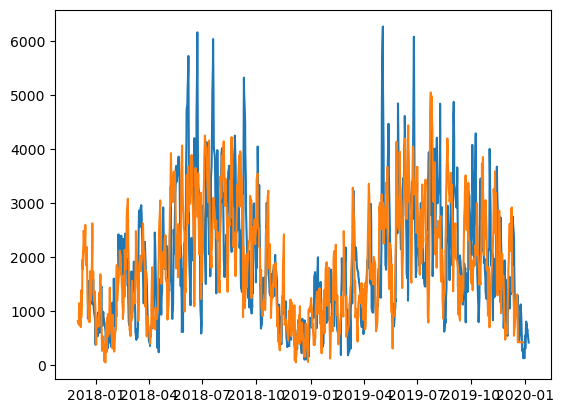

In [20]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

### PR to VicSill

In [21]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [22]:
PRtovs_rosb

2017-12-10    1310.770747
2017-12-11    1871.730525
2017-12-12    1910.283706
2017-12-13    3093.747551
2017-12-14    5417.023974
                 ...     
2019-12-24    3082.409758
2019-12-25    2294.534610
2019-12-26    1786.952666
2019-12-27    1845.328471
2019-12-28    1464.809854
Length: 749, dtype: float64

In [23]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

In [24]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.6942899962564093


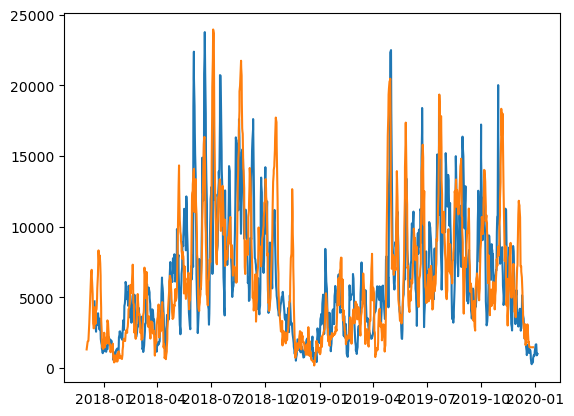

In [25]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

0.7775770719578141


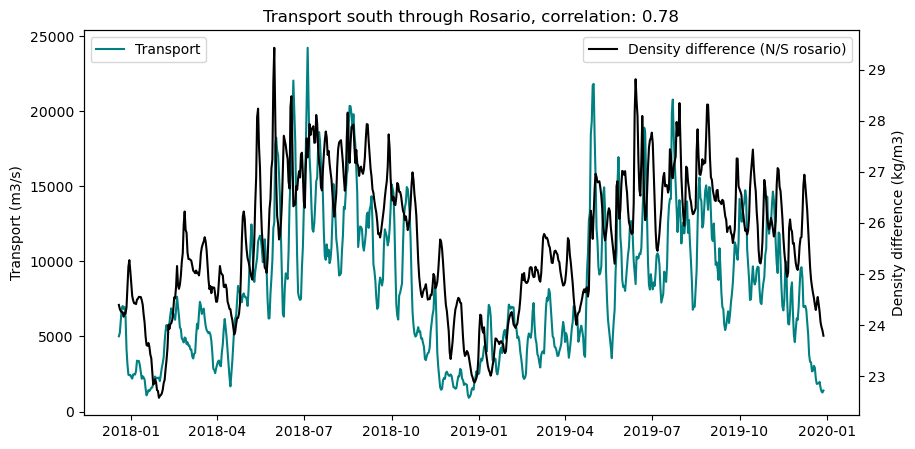

In [26]:
rostosouth = PRtovs_ros_avg + PRtoadm_ros_avg
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())
print(corr_rostosouth)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

2514.3780691952775 -56353.184153881426


Text(0.5, 1.0, 'South through rosario, correlation = -0.215')

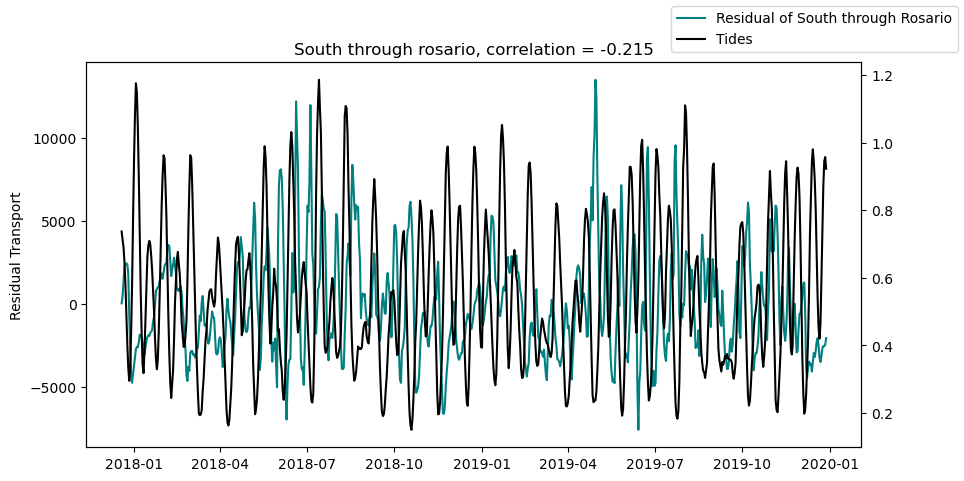

In [27]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline
print(slope,intercept)

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr_res_ros,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'South through rosario, correlation = {np.round(corr_res_ros,3)}')

In [28]:
tides.vozocrtx

0            NaN
1            NaN
2       0.607365
3       0.508302
4       0.436066
          ...   
2186    0.908305
2187    0.787567
2188    0.629463
2189    0.472127
2190         NaN
Name: vozocrtx, Length: 2191, dtype: float64

Text(0.5, 1.0, 'corr = -0.24')

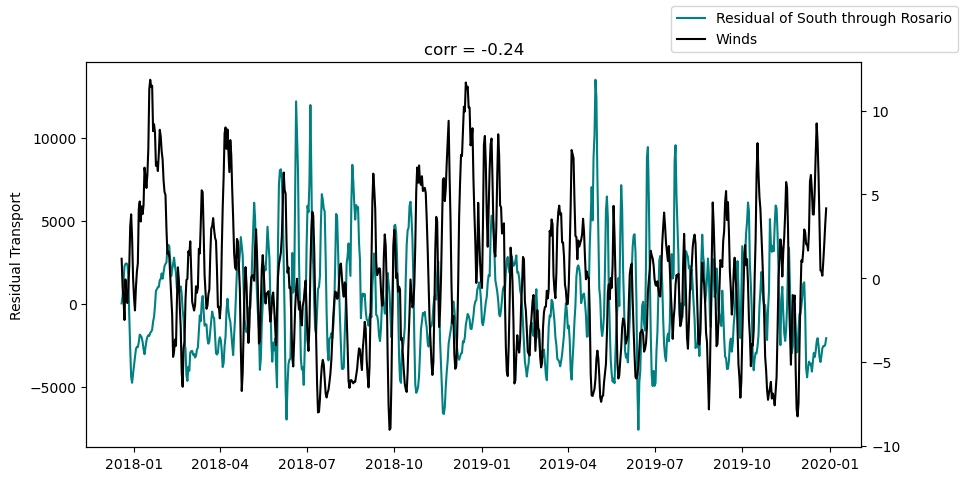

In [29]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr_res_ros_wind,p = stats.spearmanr(winds_sh,res)
corr_res_ros_wind

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_ros_wind,3)}')

### Through Haro

Now need:
- PR to adm
- PR to VS
- Gulf to adm
- Gulf to VS

4 and then combine them as before

#### PR to VicSill

In [30]:
PRtovs_harol = sectransp_2018['forpr_haro3'][6]
PRtovs_harobl = sectransp_2018['backvs_haro3'][6]

PRtovs_haro = pd.Series(PRtovs_harol,index=datelist_vs)
PRtovs_harob = pd.Series(PRtovs_harobl,index=datelist_vs)

In [31]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_haro,age_2018['forpr_haro3'][6],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.66:
            print (base, factor, corr_arr[i, j])

In [32]:
i_base_vs_haro,i_factor_vs_haro = np.where(corr_arr==np.max(corr_arr))

base_vs_haro = base_arr[i_base_vs_haro]
factor_vs_haro = factor_arr[i_factor_vs_haro]

print(base_vs_haro,factor_vs_haro)

[-0.7] [0.25]


0.5738855298712311


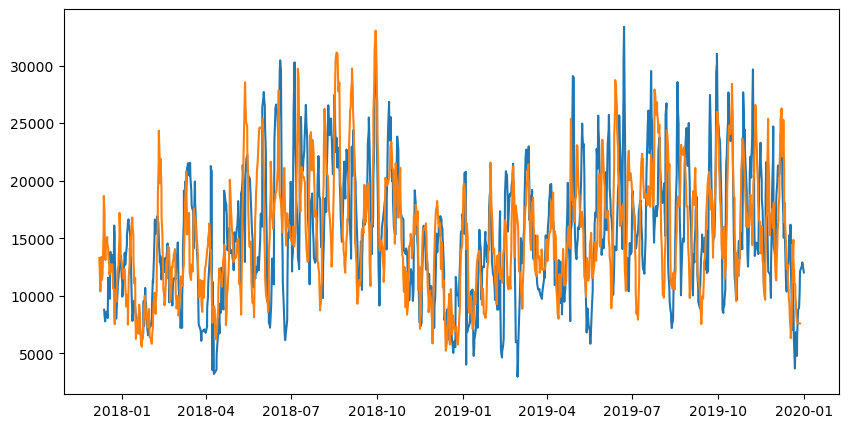

In [33]:
PRtovs_haro_sh = shift_time(PRtovs_haro,age_2018['forpr_haro3'][5],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
PRtovs_harob_sh = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

PRtovs_haro_m,PRtovs_harob_m,c,PRtovs_haro_avg = merge(PRtovs_haro_sh,PRtovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtovs_haro_m.Transport)
ax.plot(PRtovs_harob_m.Transport)

Why do these 2 look so different????

#### PR to adm

Negligible

In [34]:
# PRtoadm_harol = sectransp_2018['forpr_haro3'][2]
# PRtoadm_harobl = sectransp_2018['backadm_haro3'][6]

# PRtoadm_haro = pd.Series(PRtoadm_harol,index=datelist_vs)
# PRtoadm_harob = pd.Series(PRtoadm_harobl,index=datelist_vs)

In [35]:
# plt.plot(PRtoadm_haro)
# plt.plot(PRtoadm_harob)

These is essentially insignificant when comparing to whats going to VicSill -> ignore PR to VS

#### Gulf to VicSill

In [36]:
Gulftovs_harol = sectransp_2018['forgulf_haro3'][7]
Gulftovs_harobl = sectransp_2018['backvs_haro3'][7]

Gulftovs_haro = pd.Series(Gulftovs_harol,index=datelist_vs)
Gulftovs_harob = pd.Series(Gulftovs_harobl,index=datelist_vs)

In [37]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base,factor)
        dfr2 = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])

In [38]:
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

[0.9] [0.3]


0.3543425210319445


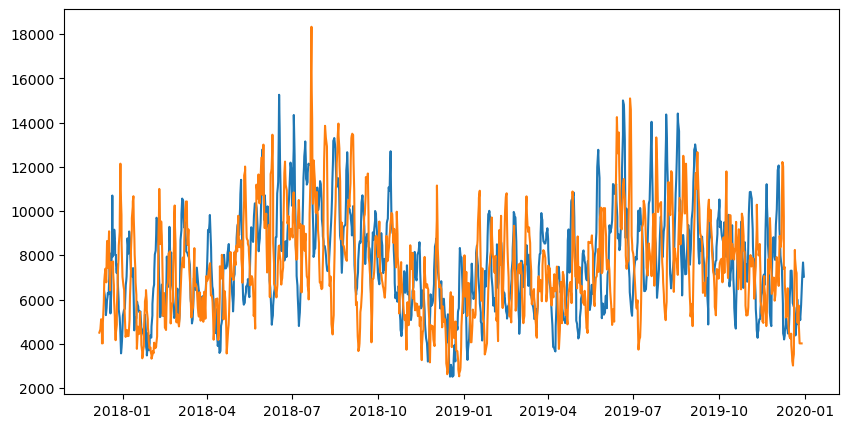

In [39]:
Gulftovs_haro_sh = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
Gulftovs_harob_sh = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs_haro_m,Gulftovs_harob_m,c,Gulftovs_haro_avg = merge(Gulftovs_haro_sh,Gulftovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs_haro_m.Transport)
ax.plot(Gulftovs_harob_m.Transport)

Gulf to VicSill more significnt than PointRob to VicSill

#### Gulf to adm

Negligible

In [40]:
# Gulftoadm_harol = sectransp_2018['forgulf_haro3'][2]
# Gulftoadm_harobl = sectransp_2018['backadm_haro3'][7]

# Gulftoadm_haro = pd.Series(Gulftoadm_harol,index=datelist_vs)
# Gulftoadm_harob = pd.Series(Gulftoadm_harobl,index=datelist_vs)

In [41]:
# plt.plot(Gulftoadm_haro)
# plt.plot(Gulftoadm_harob)

Gulf to admiralty also basically insignificant

Text(0, 0.5, 'Transport (m3/s)')

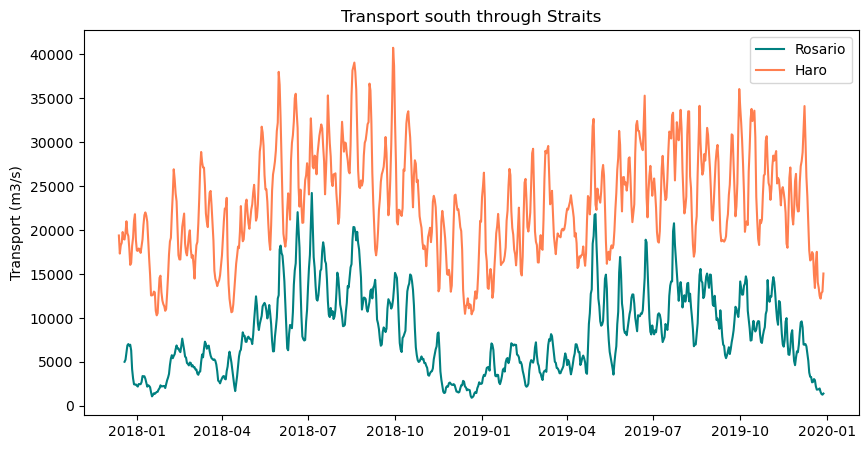

In [42]:
harotosouth = PRtovs_haro_avg + Gulftovs_haro_avg
date_harosh = list(harotosouth.dropna().index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),label='Rosario',color='teal')
ax.plot(harotosouth.dropna(),label='Haro',color='coral')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

In [43]:
corr_haroros,p = stats.spearmanr(rostosouth.dropna(),harotosouth.dropna()[6:])
print(corr_haroros)

0.6934841104629581


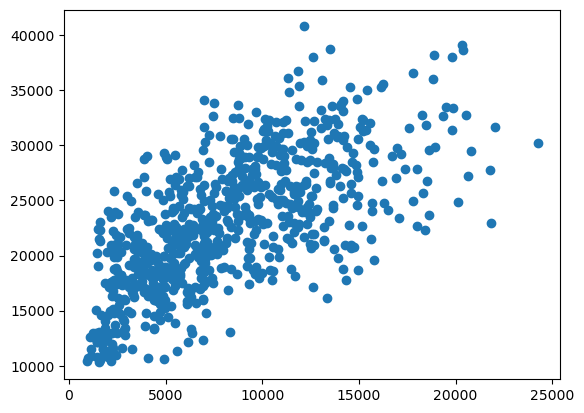

In [44]:
plt.scatter(rostosouth.dropna(),harotosouth.dropna()[6:])

#### Correlations with transport south through Haro

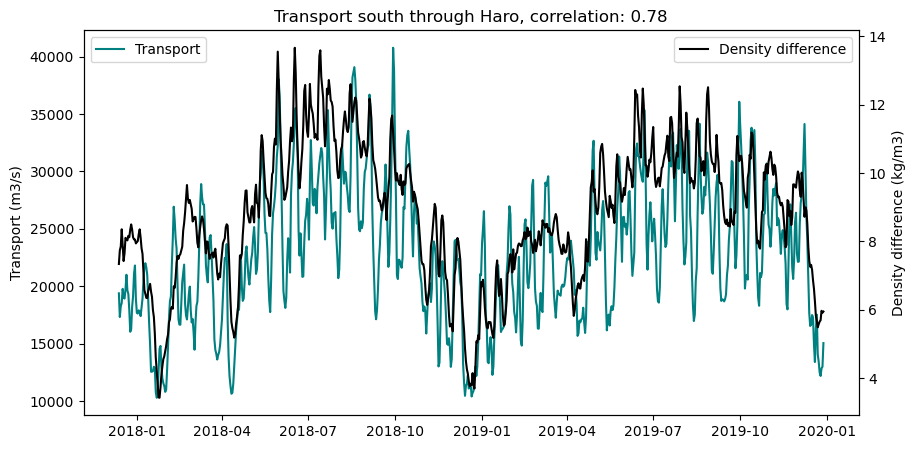

In [45]:
date_harosh = list(harotosouth.dropna().index)

mask = np.isin(datelist_dens,date_harosh)
densdiff_haro = dens_diff_vspr[mask]
date_dens_haro_sh = np.array(datelist_dens)[mask]

corr_harotosouth,p = stats.spearmanr(densdiff_haro,harotosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_haro_sh,densdiff_haro,color='k',label='Density difference')
ax.set_title(f'Transport south through Haro, correlation: {np.round(corr_harotosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

Find density difference N/S through Haro to increase this correlation?

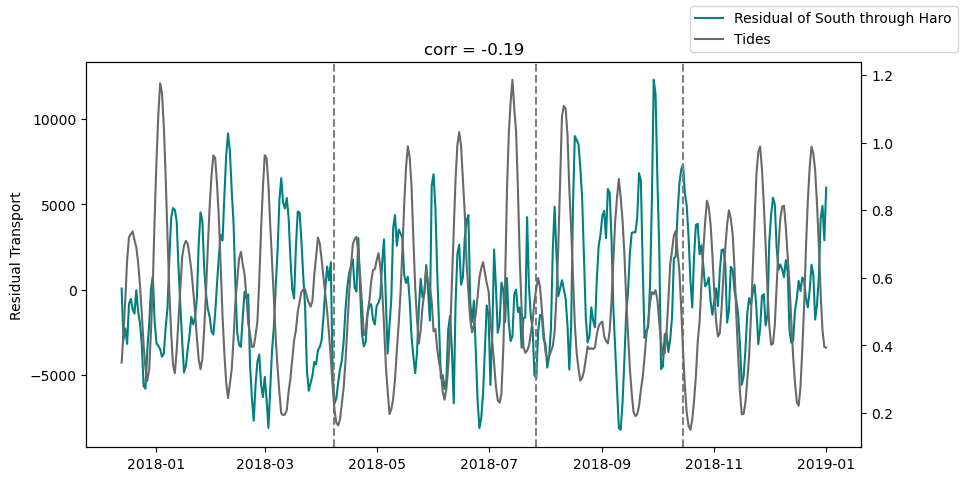

In [46]:
slope,intercept = np.polyfit(densdiff_haro,harotosouth.dropna(),1)
ddline_haro = slope*densdiff_haro+intercept
res_haro = harotosouth.dropna() - ddline_haro

mask = np.isin(datelist_tides,date_harosh)
date_tides_haro_sh = np.array(datelist_tides)[mask]
tides_haro_sh = tides.vozocrtx[mask]

corr_res_haro,p = stats.spearmanr(tides_haro_sh[0:385],res_haro[0:385])

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro[0:385],color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_sh[0:385],tides_haro_sh[0:385],color='dimgrey',label='Tides')
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_haro,3)}')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
# ax.plot(res,label='Residual south through Rosario',color='darkblue')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[300],ls='--',color='grey')
# ax3 = ax.twinx()
# ax3.plot(date_winds_sh,winds_sh,color='darkgrey',label='Winds')
# ax3.spines['right'].set_position(('outward', 80))
fig.legend()

In [47]:
corr,p = stats.spearmanr(tides_haro_sh[0:110],res_haro[0:110])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[100:200],res_haro[100:200])
print(corr)

-0.5273358429321732
0.21846984698469846


Text(0, 0.5, 'Wind velocity')

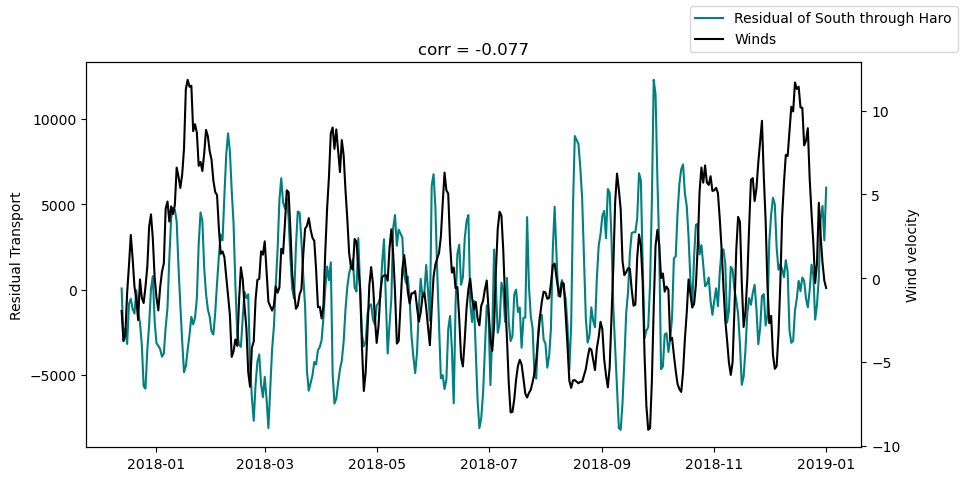

In [48]:
mask = np.isin(datelist_winds,date_harosh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_haro = y_mean4[mask]

corr,p = stats.spearmanr(winds_haro[0:385],res_haro[0:385])
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro[0:385],color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_winds_sh[0:385],winds_haro[0:385],color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Wind velocity')

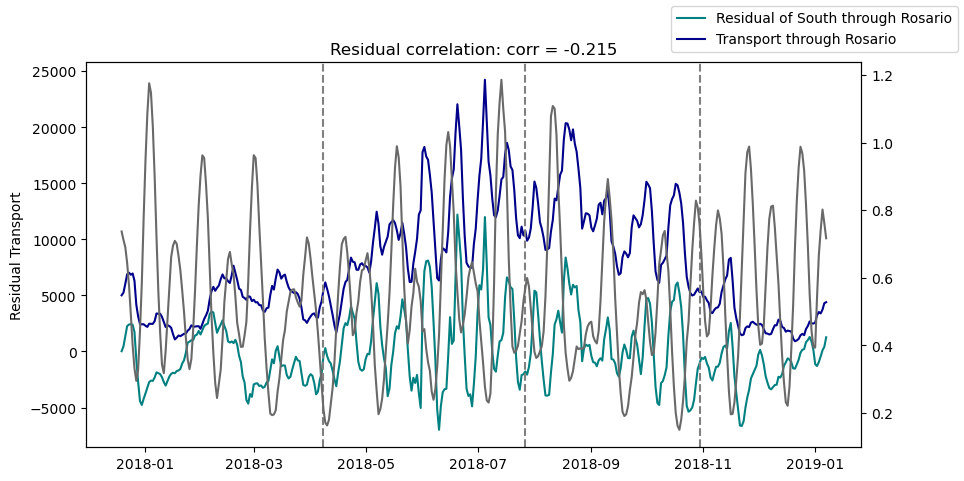

In [49]:
corr,p = stats.spearmanr(winds_haro[0:385],res_haro[0:385])
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res[0:385],color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh[0:385],tides_sh[0:385],color='dimgrey')
ax.plot(rostosouth.dropna()[0:385],color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'Residual correlation: corr = {np.round(corr_res_ros,3)}')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

Look at correlation in zone 2 of tides with residual Rosario transport. Zone 2 looks like its better (inversely) correlated with the tides than the others

In [50]:
print(f'\n ---- Overall ---- \n')

corr,p = stats.spearmanr(tides_haro_sh,res_haro)
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro,res_haro)
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh,res)
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh,res)
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[6:],rostosouth.dropna())
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh,winds_sh)
print('Tides and Winds (Ros):',corr6)
corr7,p = stats.spearmanr(tides_haro_sh,winds_haro)
print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 1 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[23:113],res_haro[23:113])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[23:113],res_haro[23:113])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[20:110],res[20:110])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[20:110],res[20:110])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[23:113],rostosouth.dropna()[20:110])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[20:110],winds_sh[20:110])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[23:113],winds_haro[23:113])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 2 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[113:223],res_haro[113:223])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[113:223],res_haro[113:223])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[110:220],res[110:220])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[110:220],res[110:220])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[113:223],rostosouth.dropna()[110:220])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[110:220],winds_sh[110:220])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[113:223],winds_haro[113:223])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 3 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[223:303],res_haro[223:303])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[223:303],res_haro[223:303])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[220:300],res[220:300])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[220:300],res[220:300])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[223:303],rostosouth.dropna()[220:300])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[220:300],winds_sh[220:300])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[223:303],winds_haro[223:303])
# print('Tides and Winds (Haro):',corr7)

print(f'\n ---- ZONE 4 ---- \n')

corr,p = stats.spearmanr(tides_haro_sh[303:],res_haro[303:])
print('Tides and Haro:',corr)
corr2,p = stats.spearmanr(winds_haro[303:],res_haro[303:])
print('Winds and Haro:',corr2)
corr3,p = stats.spearmanr(tides_sh[300:],res[300:])
print('Tides and Ros',corr3)
corr4,p = stats.spearmanr(winds_sh[300:],res[300:])
print('Winds and Ros:',corr4)
corr5,p = stats.spearmanr(harotosouth.dropna()[306:],rostosouth.dropna()[300:])
print('Haro and Ros:',corr5)
corr6,p = stats.spearmanr(tides_sh[300:],winds_sh[300:])
print('Tides and Winds (Ros):',corr6)
# corr7,p = stats.spearmanr(tides_haro_sh[303:],winds_haro[303:])
# print('Tides and Winds (Haro):',corr7)


 ---- Overall ---- 

Tides and Haro: -0.2226348292209809
Winds and Haro: -0.05428582639390351
Tides and Ros -0.215282775228648
Winds and Ros: -0.24042429351168043
Haro and Ros: 0.6934841104629581
Tides and Winds (Ros): 0.009208553329342447
Tides and Winds (Haro): 0.012210780614586383

 ---- ZONE 1 ---- 

Tides and Haro: -0.6488290735481745
Winds and Haro: 0.05739803267893155
Tides and Ros -0.11007943367493928
Winds and Ros: 0.05379264929826728
Haro and Ros: 0.6611598139688026
Tides and Winds (Ros): 0.07560604189817673

 ---- ZONE 2 ---- 

Tides and Haro: 0.2167346662759507
Winds and Haro: -0.09149516488966031
Tides and Ros -0.1453057728287086
Winds and Ros: 0.005044744494285778
Haro and Ros: 0.8726325992381039
Tides and Winds (Ros): -0.43130085882379465

 ---- ZONE 3 ---- 

Tides and Haro: -0.28241912798874824
Winds and Haro: -0.14036568213783404
Tides and Ros -0.2895452414439757
Winds and Ros: -0.15782934833567747
Haro and Ros: 0.6559774964838256
Tides and Winds (Ros): 0.073652133145

Look at the correlation with density difference b/w VicSill and PR (vs. N/S of Rosario)

**High correlation of transport to the wind (likely because the wind and density difference are highly correlated) - residual high correlation with the tides and very low with the winds

0.10997002006176317
-0.09116155354687464
-0.1453057728287086
0.03182381714491806


Text(0.5, 1.0, 'Zone 2: Correlation: 0.11')

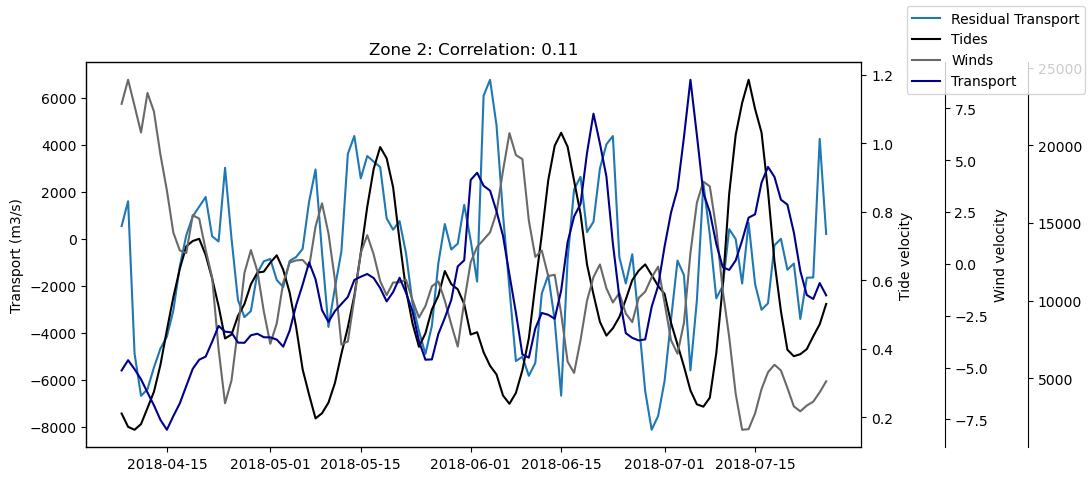

In [51]:
aa = date_tides_sh[110:220]
a = res_haro[113:223]
b = tides_sh[110:220]
c = winds_sh[110:220]
d = rostosouth.dropna()[110:220]
e = res[110:220]

corr1,p = stats.spearmanr(a,b)
print(corr1)
corr2,p = stats.spearmanr(a,c)
print(corr2)
corr3,p = stats.spearmanr(b,e)
print(corr3)
corr4,p = stats.spearmanr(b,d)
print(corr4)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(aa,a,label='Residual Transport')
ax2 = ax.twinx()
ax2.plot(aa,b,color='k',label='Tides')
ax3 = ax.twinx()
ax3.plot(aa,c,color='dimgrey',label='Winds')
ax3.spines['right'].set_position(('outward', 60))
ax4 = ax.twinx()
ax4.plot(aa,d,color='darkblue',label='Transport')
ax4.spines['right'].set_position(('outward', 120))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Wind velocity')
fig.legend()
ax.set_title(f'Zone 2: Correlation: {np.round(corr1,3)}')

Correlation with residual rosTsouth is high... but positive. Even higher than through Haro.

If we look at density difference from Rosario to PR its higher ... So stick with this
(try from PR to VS?) - How to tell which density difference I'm even looking at ?? IDK that's my fault

### North through Haro

#### VicSill to Point Rob

In [111]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2019,12,28)

datelist_forvs_haro = []

while date <= enddate:
    datelist_forvs_haro.append(date)
    date+=dt.timedelta(days=1)
    
datelist_forvs_haro.pop(506)

datetime.datetime(2019, 4, 30, 0, 0)

In [115]:
VStoPR_harol = sectransp_2018['forvs_haro3'][6]
VStoPR_harobl = sectransp_2018['backpr_haro3'][6]

VStoPR_haro = pd.Series(VStoPR_harol,index=datelist_forvs_haro)
VStoPR_harob = pd.Series(VStoPR_harobl,index=datelist_vs)

In [116]:
factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoPR_haro,age_2018['forvs_haro3'][6],datelist_forvs_haro,base,factor)
        dfr2 = shift_time(VStoPR_harob,age_2018['backpr_haro3'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])

0.40000000000000124 0.2500000000000011 0.7602977285240061
0.4500000000000013 0.2500000000000011 0.7600663516890054


In [117]:
i_base_vs2pr,i_factor_vs2pr = np.where(corr_arr==np.max(corr_arr))

base_vs2pr = base_arr[i_base_vs2pr]
factor_vs2pr = factor_arr[i_factor_vs2pr]

print(base_vs2pr,factor_vs2pr)

[0.4] [0.25]


0.7387501234657728


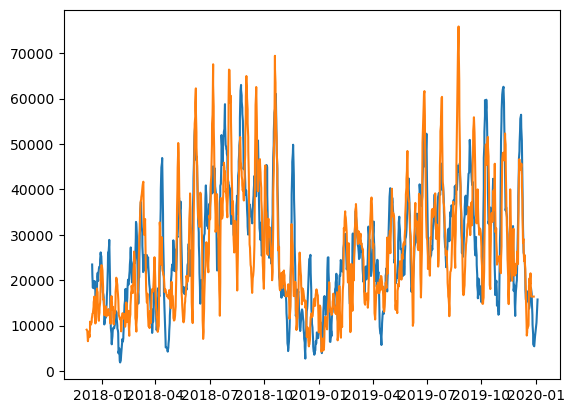

In [118]:
VStoPR_haro_sh = shift_time(VStoPR_haro,age_2018['forvs_haro3'][6],datelist_forvs_haro,base_vs2pr[0],factor_vs2pr[0])
VStoPR_harob_sh = shift_time(VStoPR_harob,age_2018['backvs_haro3'][6],datelist_vs,-base_vs2pr[0],-factor_vs2pr[0])

VStoPR_haro_m,VStoPR_harob_m,c,VStoPR_haro_avg = merge(VStoPR_haro_sh,VStoPR_harob_sh)
print(c)

plt.plot(VStoPR_haro_m.Transport)
plt.plot(VStoPR_harob_m.Transport)

#### VS to Gulf

In [119]:
VStogulf_harol = sectransp_2018['forvs_haro3'][7]
VStogulf_harobl = sectransp_2018['backgulf_haro3'][7]

VStogulf_haro = pd.Series(VStogulf_harol,index=datelist_forvs_haro)
VStogulf_harob = pd.Series(VStogulf_harobl,index=datelist_vs)

In [120]:
factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStogulf_haro,age_2018['forvs_haro3'][7],datelist_forvs_haro,base,factor)
        dfr2 = shift_time(VStogulf_harob,age_2018['backgulf_haro3'][7],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])

In [121]:
i_base_vs2gulf,i_factor_vs2gulf = np.where(corr_arr==np.max(corr_arr))

base_vs2gulf = base_arr[i_base_vs2gulf]
factor_vs2gulf = factor_arr[i_factor_vs2gulf]

print(base_vs2gulf,factor_vs2gulf)

[-0.25] [0.4]


0.6965776214794521


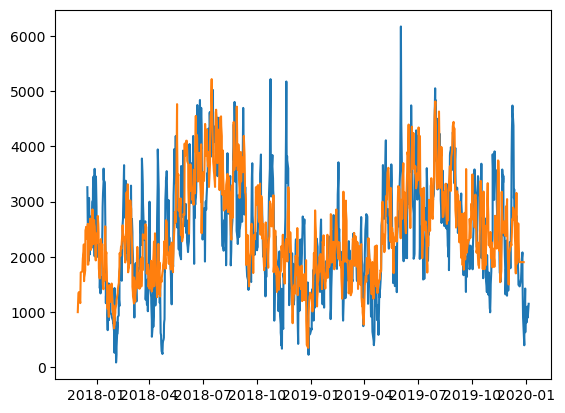

In [122]:
VStogulf_haro_sh = shift_time(VStogulf_haro,age_2018['forvs_haro3'][7],datelist_forvs_haro,base_vs2gulf[0],factor_vs2gulf[0])
VStogulf_harob_sh = shift_time(VStogulf_harob,age_2018['backgulf_haro3'][7],datelist_vs,-base_vs2gulf[0],-factor_vs2gulf[0])

VStogulf_haro_m,VStogulf_harob_m,c,VStogulf_haro_avg = merge(VStogulf_haro_sh,VStogulf_harob_sh)
print(c)

plt.plot(VStogulf_haro_m.Transport)
plt.plot(VStogulf_harob_m.Transport)

#### Adm to PR 

Negligible

In [125]:
AdmtoPR_harol = sectransp_2018['foradm_haro3'][6]
AdmtoPR_harobl = sectransp_2018['backpr_haro3'][2][0:385]

AdmtoPR_haro = pd.Series(AdmtoPR_harol,index=datelist_vs[0:385])
AdmtoPR_harob = pd.Series(AdmtoPR_harobl,index=datelist_vs[0:385])

In [126]:
factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(AdmtoPR_haro,age_2018['foradm_haro3'][6],datelist_vs[0:385],base,factor)
        dfr2 = shift_time(AdmtoPR_harob,age_2018['backpr_haro3'][2],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.76:
            print (base, factor, corr_arr[i, j])

In [127]:
i_base_adm2pr,i_factor_adm2pr = np.where(corr_arr==np.max(corr_arr))

base_adm2pr = base_arr[i_base_adm2pr]
factor_adm2pr = factor_arr[i_factor_adm2pr]

print(base_adm2pr,factor_adm2pr)

[0.4] [0.3]


0.6832079157850631


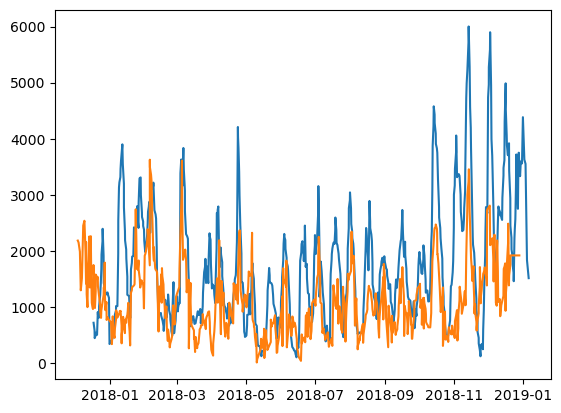

In [128]:
AdmtoPR_haro_sh = shift_time(AdmtoPR_haro,age_2018['foradm_haro3'][6],datelist_vs[0:385],base_adm2pr[0],factor_adm2pr[0])
AdmtoPR_harob_sh = shift_time(AdmtoPR_harob,age_2018['backpr_haro3'][2],datelist_vs[0:385],-base_adm2pr[0],-factor_adm2pr[0])

AdmtoPR_haro_m,AdmtoPR_harob_m,c,AdmtoPR_haro_avg = merge(AdmtoPR_haro_sh,AdmtoPR_harob_sh)
print(c)

plt.plot(AdmtoPR_haro_m.Transport)
plt.plot(AdmtoPR_harob_m.Transport)

#### Adm to Gulf

In [130]:
Admtogulf_harol = sectransp_2018['foradm_haro3'][7]
Admtogulf_harobl = sectransp_2018['backgulf_haro3'][2][0:385]

Admtogulf_haro = pd.Series(Admtogulf_harol,index=datelist_vs[0:385])
Admtogulf_harob = pd.Series(Admtogulf_harobl,index=datelist_vs[0:385])

In [131]:
np.max(Admtogulf_harob)

606.6185161355382

In [133]:
# factor_arr = np.arange(-1,1,0.05)
# base_arr = np.arange(-1,1,0.05)

# corr_arr = np.zeros([len(base_arr),len(factor_arr)])

# for i,base in enumerate(base_arr):
#     for j,factor in enumerate(factor_arr):
#         dfr1 = shift_time(Admtogulf_haro,age_2018['foradm_haro3'][7],datelist_vs[0:385],base,factor)
#         dfr2 = shift_time(Admtogulf_harob,age_2018['backgulf_haro3'][2][0:385],datelist_vs[0:385],-base,-factor)
#         dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
#         if corr_arr[i,j] > 0.76:
#             print (base, factor, corr_arr[i, j])

Text(0, 0.5, 'Transport (m3/s)')

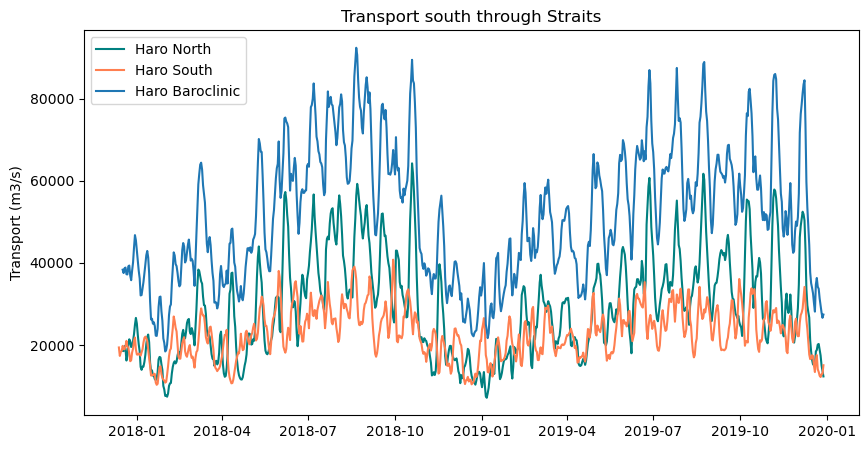

In [139]:
harotonorth = VStogulf_haro_avg + VStoPR_haro_avg
date_haroNsh = list(harotonorth.dropna().index)
haro_bclin = (harotosouth.dropna()+harotonorth.dropna()).dropna()
date_haro_bclin = list(haro_bclin.index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotonorth.dropna(),label='Haro North',color='teal')
ax.plot(harotosouth.dropna(),label='Haro South',color='coral')
ax.plot(haro_bclin.dropna(),label='Haro Baroclinic')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

In [140]:
corr = stats.spearmanr(harotonorth.dropna(),haro_bclin.dropna())
print(corr)
corr = stats.spearmanr(harotosouth.dropna()[5:],haro_bclin.dropna())
print(corr)

SignificanceResult(statistic=0.9525091216253084, pvalue=0.0)
SignificanceResult(statistic=0.7833251292039773, pvalue=9.640487606493673e-155)


#### Correlations with baroclinic velocity

0.8073293302687545


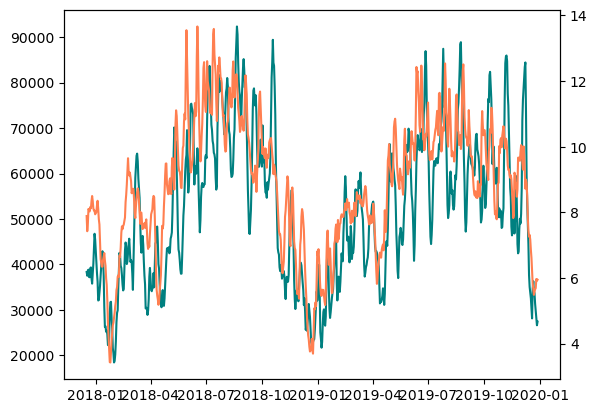

In [141]:
mask = np.isin(datelist_dens,date_haro_bclin)
densdiff_haro_bclin = dens_diff_vspr[mask]
date_dens_haro_bclin = np.array(datelist_dens)[mask]

corr_haro_bclin_DD,p = stats.spearmanr(densdiff_haro_bclin,haro_bclin)
print(corr_haro_bclin_DD)

fig,ax = plt.subplots()

ax.plot(haro_bclin,color='teal',label='Baroclinic Transport - Haro')
ax2 = ax.twinx()
ax2.plot(date_dens_haro_bclin,densdiff_haro_bclin,color='coral')

In [142]:
mask = np.isin(datelist_dens,date_harosh)
densdiff_vspr_haroS = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_vspr_haroS,harotosouth.dropna())
corr

0.7830357289315238

In [143]:
mask = np.isin(datelist_dens,date_haroNsh)
densdiff_vspr_haroN = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_vspr_haroN,harotonorth.dropna())
corr

0.7068339856820494

North is less correlated with density difference. Baroclinic and south are about the same

0.7068339856820494


Text(0, 0.5, 'Tide velocity ')

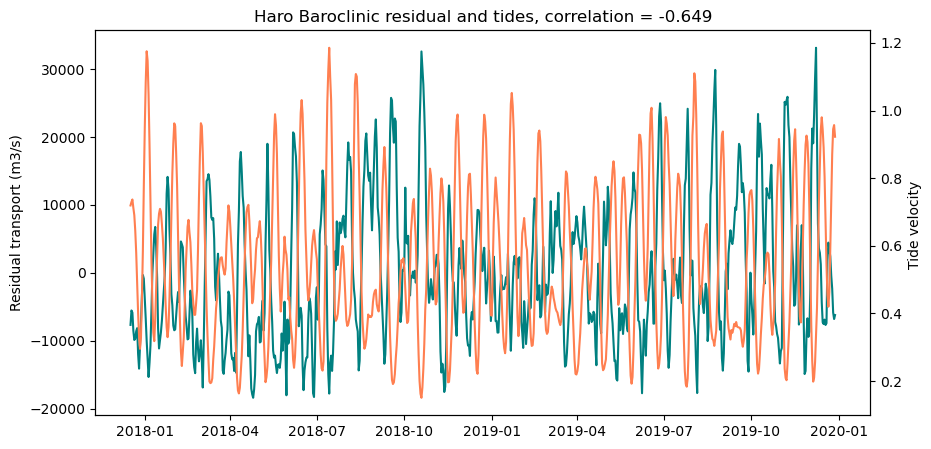

In [144]:
slope,intercept = np.polyfit(densdiff_haro_bclin,haro_bclin,1)
ddline_haro_bclin = slope*densdiff_haro_bclin+intercept
res_haro_bclin = haro_bclin - ddline_haro_bclin

mask = np.isin(datelist_tides,date_haro_bclin)
tides_haro_bclin = tides.vozocrtx[mask]
date_tides_haro_bclin = np.array(datelist_tides)[mask]

corr_res_haro_bclin_tides,p = stats.spearmanr(tides_haro_bclin,res_haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,label='Residual Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_bclin,tides_haro_bclin,color='coral',label='Tides')
ax.set_title(f'Haro Baroclinic residual and tides, correlation = {np.round(corr_res_haro_bclin_tides,3)}')
# ax.axvline(date_tides_sh[idx_z2],ls='--',color='grey')
# ax.axvline(date_tides_sh[idx_z3],ls='--',color='grey')
# ax.axvline(date_tides_sh[idx_z4],ls='--',color='grey')
# ax.axvline(date_tides_sh[idx_z1],ls='--',color='grey')
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

Baroclinic velocity strongly negatively correlated ... but south flow NOT

Check north flow ...

-0.6039721946375374


Text(0, 0.5, 'Tide velocity ')

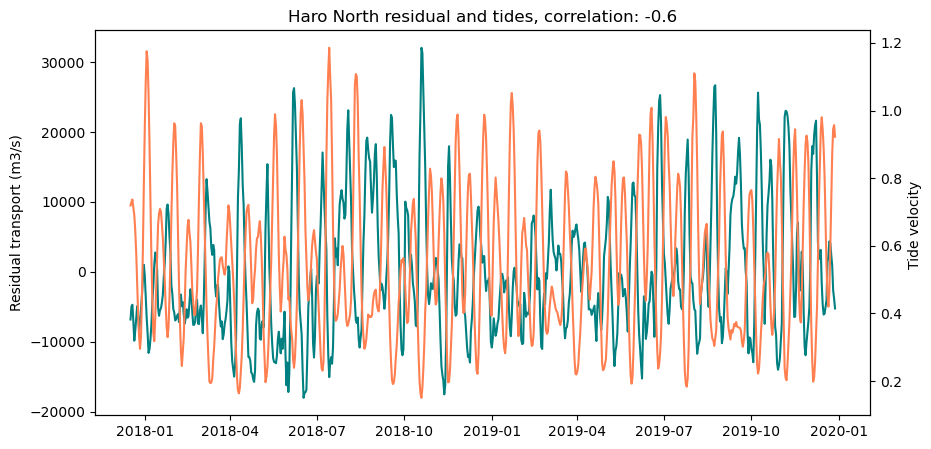

In [159]:
slope,intercept = np.polyfit(densdiff_vspr_haroN,harotonorth.dropna(),1)

ddline_haroN = slope*densdiff_vspr_haroN+intercept
res_haroN = harotonorth.dropna() - ddline_haroN

mask = np.isin(datelist_tides,date_haroNsh)
tides_haroN = tides.vozocrtx[mask]
date_tides_haroN = np.array(datelist_tides)[mask]

corr,p = stats.spearmanr(tides_haroN,res_haroN)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haroN,color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haroN,tides_haroN,color='coral')
ax.set_title(f'Haro North residual and tides, correlation: {np.round(corr,2)}')
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

-0.565353736289617
-0.6507776334144989


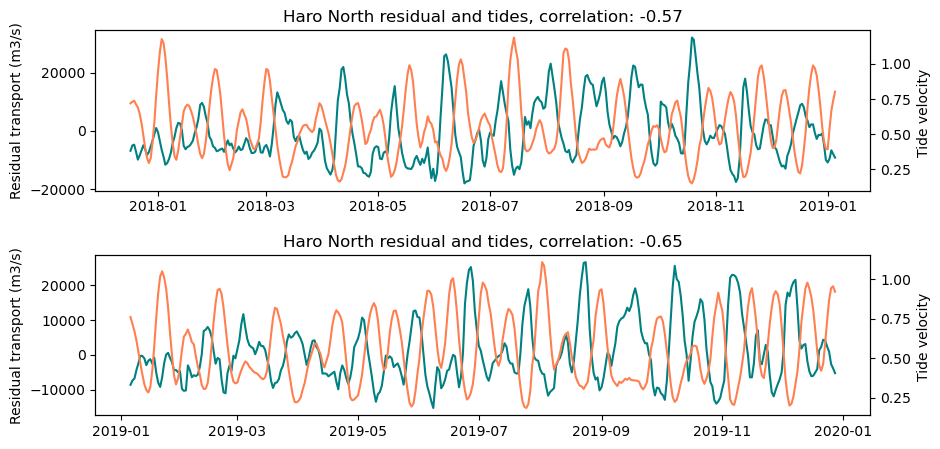

In [163]:
corr,p = stats.spearmanr(tides_haroN[0:385],res_haroN[0:385])
print(corr)

fig,[ax,ax3] = plt.subplots(2,1,figsize=(10,5))

ax.plot(res_haroN[0:385],color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haroN[0:385],tides_haroN[0:385],color='coral')
ax.set_title(f'Haro North residual and tides, correlation: {np.round(corr,2)}')
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

corr,p = stats.spearmanr(tides_haroN[385:],res_haroN[385:])
print(corr)

ax3.plot(res_haroN[385:],color='teal')
ax32 = ax3.twinx()
ax32.plot(date_tides_haroN[385:],tides_haroN[385:],color='coral')
ax3.set_title(f'Haro North residual and tides, correlation: {np.round(corr,2)}')
ax3.set_ylabel('Residual transport (m3/s)')
ax32.set_ylabel('Tide velocity ')

fig.subplots_adjust(hspace=0.4)

-0.2226348292209809


Text(0, 0.5, 'Tide velocity ')

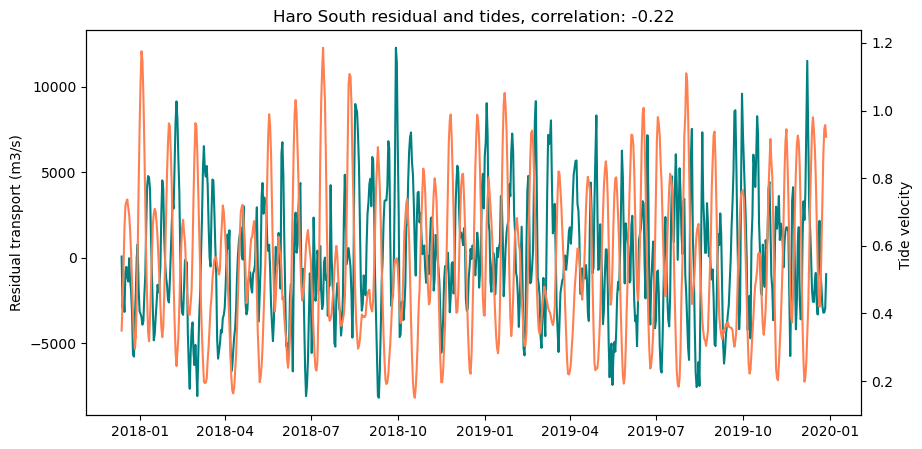

In [158]:
slope,intercept = np.polyfit(densdiff_vspr_haroS,harotosouth.dropna(),1)

ddline_haroS = slope*densdiff_vspr_haroS+intercept
res_haroS = harotosouth.dropna() - ddline_haroS

date_haroSsh = list(harotosouth.dropna().index)
mask = np.isin(datelist_tides,date_haroSsh)
tides_haroS = tides.vozocrtx[mask]
date_tides_haroS = np.array(datelist_tides)[mask]

corr,p = stats.spearmanr(tides_haroS,res_haroS)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haroS,color='teal')
# ax.plot(res_haro_bclin)
# ax.plot(res_haro,color='lightblue')
ax2 = ax.twinx()
ax2.plot(date_tides_haroS,tides_haroS,color='coral')
ax.set_title(f'Haro South residual and tides, correlation: {np.round(corr,2)}')

ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('Tide velocity ')

#### Calculate residual with density difference to Haro 

0.7830357289315238
0.7830357289315238


Text(0.5, 1.0, 'Haro South and density difference')

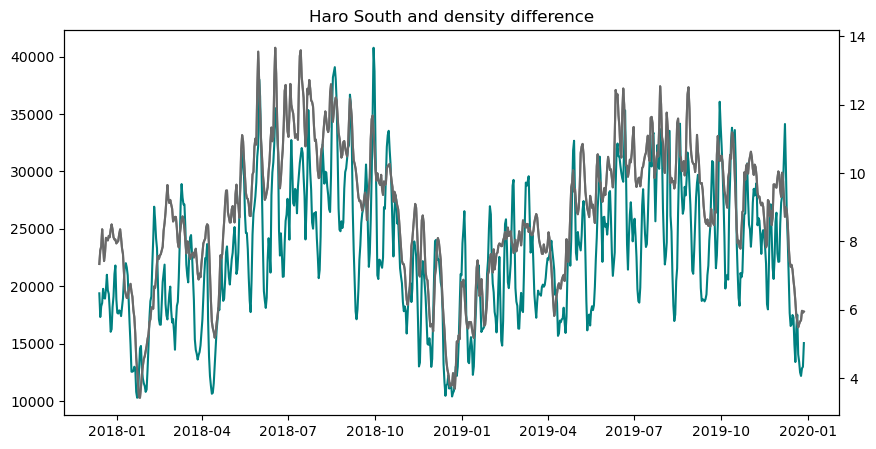

In [165]:
mask = np.isin(datelist_dens,date_harosh)
densdiff_haro2 = dens_diff_vspr[mask]

corr_harotosouth2,p = stats.spearmanr(densdiff_haro2,harotosouth.dropna())
print(corr_harotosouth2)
print(corr_harotosouth)

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(harotosouth.dropna(),color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro2,color='grey')
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro,color='dimgrey')
ax.set_title('Haro South and density difference')

-0.2226348292209809


Text(0.5, 0.98, 'HaroSouth residial and tides')

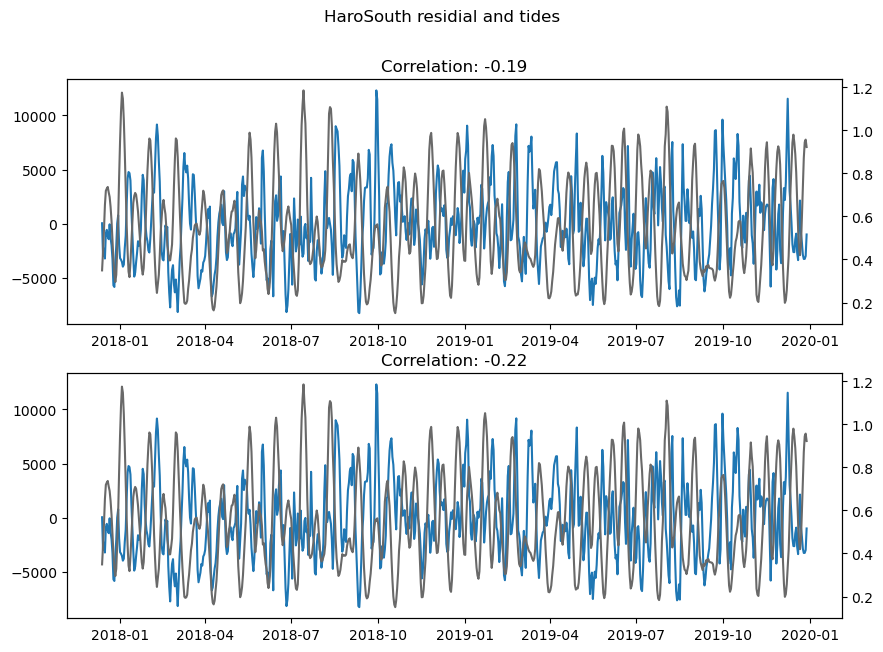

In [166]:
slope,intercept = np.polyfit(densdiff_haro2,harotosouth.dropna(),1)
ddline_haro2 = slope*densdiff_haro2+intercept
res_haro2 = harotosouth.dropna() - ddline_haro2

corr_res_haro2,p = stats.spearmanr(tides_haro_sh,res_haro2)
print(corr_res_haro2)

fig,ax = plt.subplots(2,1,figsize=(10,7))

ax[0].plot(res_haro)
ax[1].plot(res_haro2)
ax2 = ax[0].twinx()
ax2.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey')
ax3 = ax[1].twinx()
ax3.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey')
ax[0].set_title(f'Correlation: {np.round(corr_res_haro,2)}')
ax[1].set_title(f'Correlation: {np.round(corr_res_haro2,2)}')
fig.suptitle('HaroSouth residial and tides')

Text(0, 0.5, 'Tide velocity')

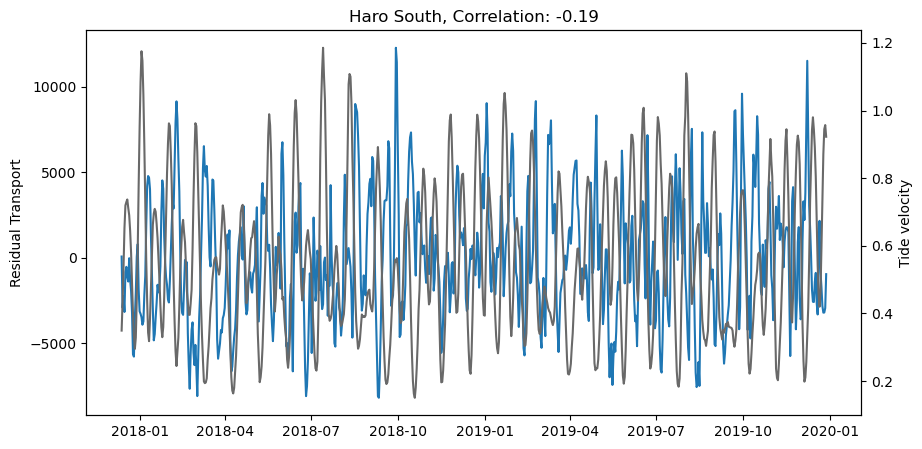

In [167]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(res_haro)
ax2 = ax.twinx()
ax2.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey')
ax.set_title(f'Haro South, Correlation: {np.round(corr_res_haro,2)}')
ax.set_ylabel('Residual Transport')
ax2.set_ylabel('Tide velocity')

- Split up baroclinic haro into the subregions
- Maximize correlation with densdiff_haro, and see if this is the same patterns as rosario

#### Baroclinic

In [168]:
idx_z1 = 15
idx_z2 = 110
idx_z3 = 240
idx_z4 = 320


transp_haro_bclinz1 = haro_bclin.dropna()[idx_z1:idx_z2]
tides_haro_bclinz1 = tides_haro_bclin[idx_z1:idx_z2]
transp_haro_bclinz2 = haro_bclin.dropna()[idx_z2:idx_z3]
tides_haro_bclinz2 = tides_haro_bclin[idx_z2:idx_z3]
transp_haro_bclinz3 = haro_bclin.dropna()[idx_z3:idx_z4]
tides_haro_bclinz3 = tides_haro_bclin[idx_z3:idx_z4]
transp_haro_bclinz4 = haro_bclin.dropna()[idx_z4:]
tides_haro_bclinz4 = tides_haro_bclin[idx_z4:]

corr,p = stats.spearmanr(tides_haro_bclinz1,transp_haro_bclinz1)
print('Zone1:',corr)
corr,p = stats.spearmanr(tides_haro_bclinz2,transp_haro_bclinz2)
print('Zone2:',corr)
corr,p = stats.spearmanr(tides_haro_bclinz3,transp_haro_bclinz3)
print('Zone3:',corr)
corr,p = stats.spearmanr(tides_haro_bclinz4,transp_haro_bclinz4)
print('Zone4:',corr)

Zone1: -0.4792413213885779
Zone2: -0.23151756817654204
Zone3: -0.7978902953586497
Zone4: -0.40323487456920604


Varying degrees of negative correlation consistent with zones from +/- of HaroS 

-> Look at HaroN

In [169]:
transp_haroNz1 = harotonorth.dropna()[idx_z1:idx_z2]
tides_haroNz1 = tides_haroN[idx_z1:idx_z2]
transp_haroNz2 = harotonorth.dropna()[idx_z2:idx_z3]
tides_haroNz2 = tides_haroN[idx_z2:idx_z3]
transp_haroNz3 = harotonorth.dropna()[idx_z3:idx_z4]
tides_haroNz3 = tides_haroN[idx_z3:idx_z4]
transp_haroNz4 = harotonorth.dropna()[idx_z4:]
tides_haroNz4 = tides_haroN[idx_z4:]

corr,p = stats.spearmanr(tides_haroNz1,transp_haroNz1)
print('Zone1:',corr)
corr,p = stats.spearmanr(tides_haroNz2,transp_haroNz2)
print('Zone2:',corr)
corr,p = stats.spearmanr(tides_haroNz3,transp_haroNz3)
print('Zone3:',corr)
corr,p = stats.spearmanr(tides_haroNz4,transp_haroNz4)
print('Zone4:',corr)

Zone1: -0.30795072788353867
Zone2: -0.3987081620669407
Zone3: -0.8079465541490858
Zone4: -0.4590519397185989


- Zone 1 to 2 switch must be because of haroS since consistent correlation in zone1
- Zone 2 to 3 switch doubles in HaroN therefore that change is because of HaroN
- Zone 3 to 4 switch must be caused by HaroS signal

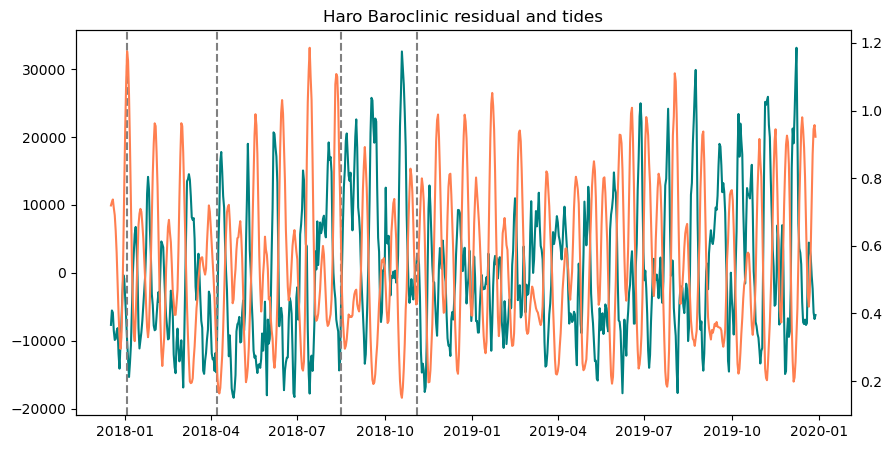

In [170]:

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,label='Residual Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_bclin,tides_haro_bclin,color='coral',label='Tides')
ax.set_title('Haro Baroclinic residual and tides')
ax.axvline(date_tides_sh[idx_z2],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z3],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z4],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z1],ls='--',color='grey')

Doesn't visually look different in the various zones

No none of these correlations mean anything. Degree of strength for HaroN is just because of how large the window is. Some of the effect on baroclinic Haro is because of HaroS and rest is product of window size

Look @ Rosario again

## Look at barotropic Haro

Text(0, 0.5, 'Transport (m3/s)')

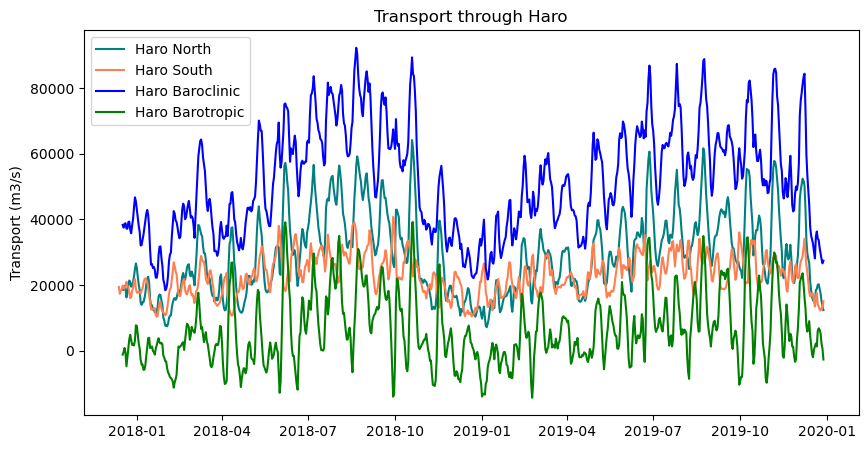

In [171]:
haro_btrop = (harotonorth-harotosouth).dropna()
date_haro_btrop = list(haro_bclin.index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotonorth.dropna(),label='Haro North',color='teal')
ax.plot(harotosouth.dropna(),label='Haro South',color='coral')
ax.plot(haro_bclin.dropna(),label='Haro Baroclinic',color='blue')
ax.plot(haro_btrop.dropna(),label='Haro Barotropic',color='green')
ax.legend()
ax.set_title(f'Transport through Haro')
ax.set_ylabel('Transport (m3/s)')

0.36211402864828884
-0.44342389138814164


Text(0, 0.5, 'Tide velocity')

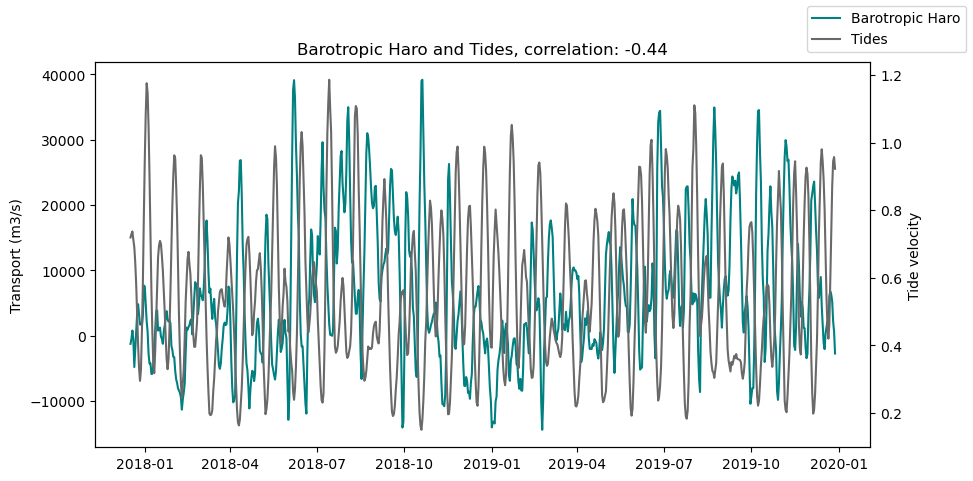

In [172]:
mask = np.isin(datelist_dens,date_haro_btrop)
densdiff_haro_btrop = dens_diff_vspr[mask]
date_DD_haro_btrop = np.array(datelist_dens)[mask]

corr_DD_haro_btrop,p = stats.spearmanr(haro_btrop,densdiff_haro_btrop)
print(corr_DD_haro_btrop)

mask = np.isin(datelist_tides,date_haro_btrop)
tides_haro_btrop = tides.vozocrtx[mask]
date_tides_haro_btrop = np.array(datelist_tides)[mask]

corr_tides_haro_btrop,p = stats.spearmanr(tides_haro_btrop,haro_btrop)
print(corr_tides_haro_btrop)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_btrop,label='Barotropic Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_btrop,tides_haro_btrop,color='dimgrey',label='Tides')
fig.legend()
ax.set_title(f'Barotropic Haro and Tides, correlation: {np.round(corr_tides_haro_btrop,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')

Text(0.5, 1.0, 'Barotropic Haro and density difference, correlation: 0.32')

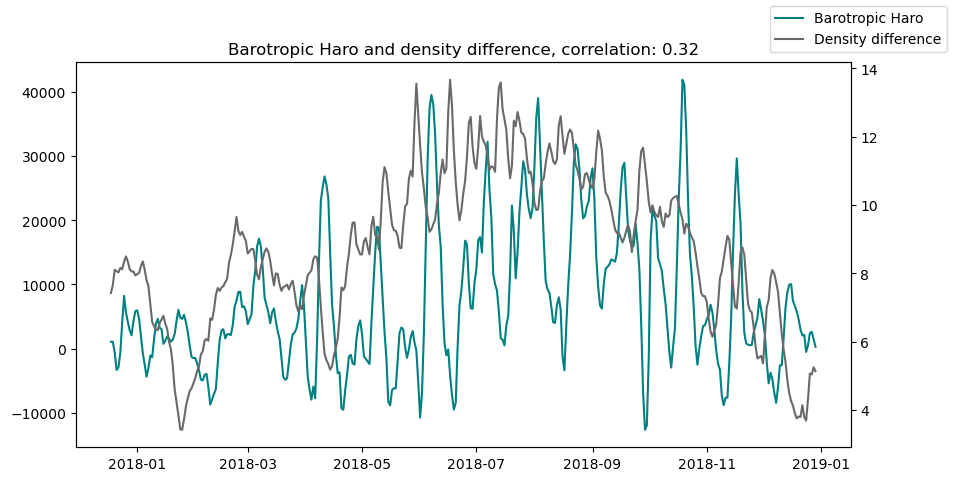

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_btrop,label='Barotropic Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_DD_haro_btrop,densdiff_haro_btrop,color='dimgrey',label='Density difference')
fig.legend()
ax.set_title(f'Barotropic Haro and density difference, correlation: {np.round(corr_DD_haro_btrop,2)}')

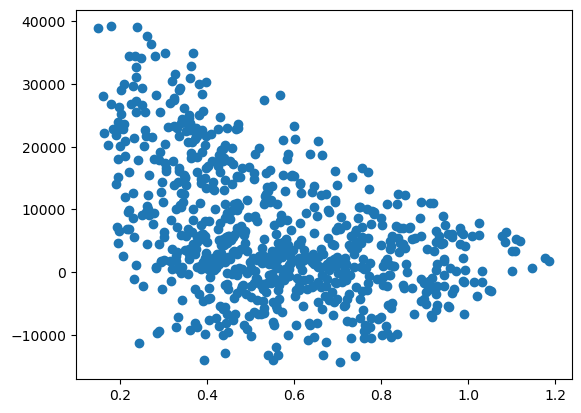

In [173]:
plt.scatter(tides_haro_btrop,haro_btrop)

In [174]:
slope,intercept = np.polyfit(tides_haro_btrop,haro_btrop,1)
tides_line_haro_btrop = slope*tides_haro_btrop+intercept
res_haro_btrop_tides = haro_btrop.values - tides_line_haro_btrop.values

corr_resharo_btrop_DD,p = stats.spearmanr(densdiff_haro_btrop,res_haro_btrop_tides)
print(corr_resharo_btrop_DD)

0.39056686355594006


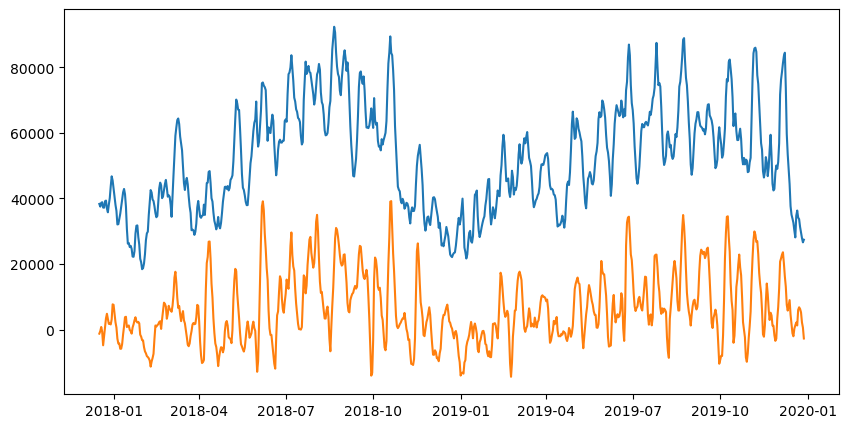

In [175]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_bclin)
ax.plot(haro_btrop)

0.6563472679659373


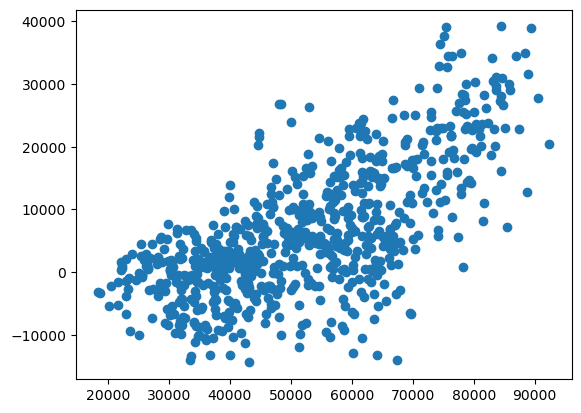

In [176]:
plt.scatter(haro_bclin,haro_btrop)
corr,p = stats.spearmanr(haro_bclin,haro_btrop)
print(corr)

### Sea Surface Height

0.2727432180262369


Text(0.5, 1.0, 'Baroclinic Haro and SSH, corr: 0.27')

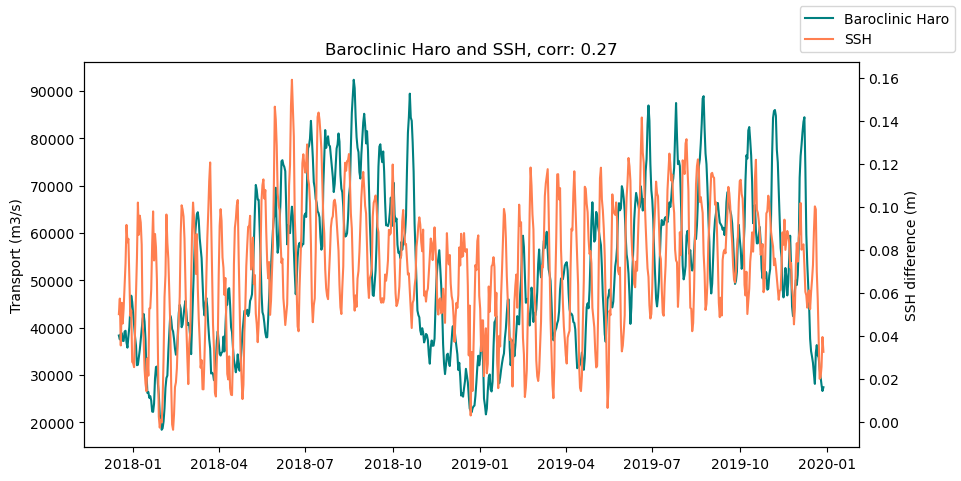

In [177]:
delta_ssh_data = pd.read_csv('../notebooks/ssh_4day_mean.csv')
ssh_vicsill_data = pd.read_csv('../notebooks/ssh_vicsill_4day_mean.csv')
jdf_vicsill_data = pd.read_csv('../notebooks/ssh_jdf_4day_mean.csv')
jdf7_vicsill_data = pd.read_csv('../notebooks/ssh_jdf_7day_mean.csv')
datelist_ssh = delta_ssh_data['Unnamed: 0']
delta_ssh = delta_ssh_data['SSH']
ssh_vicsill = ssh_vicsill_data['SSH']
ssh_jdf7 = jdf7_vicsill_data['SSH']
ssh_jdf = jdf_vicsill_data['SSH']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2020,1,31)

dates = []
datelist_ssh = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_ssh.append(date)
    date+=dt.timedelta(days=1)

#Look at through Haro (baroclinic) and SSH

mask = np.isin(datelist_ssh,date_haro_bclin)
ssh_haro_bclin = delta_ssh[mask]
date_ssh_haro_bclin = np.array(datelist_ssh)[mask]

corr,p = stats.spearmanr(ssh_haro_bclin,haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_bclin,color='teal',label='Baroclinic Haro')
ax2 = ax.twinx()
ax2.plot(date_ssh_haro_bclin,ssh_haro_bclin,color='coral',label='SSH')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('SSH difference (m)')
fig.legend()
ax.set_title(f'Baroclinic Haro and SSH, corr: {np.round(corr,2)}')


Remove tides from both and re-look

### Variance explained

In [178]:
mask = np.isin(datelist_winds,date_haro_bclin)
winds_haro_bclin = y_mean4[mask]

# Correlation of all with og transport

corr_dd,p = stats.spearmanr(densdiff_haro_bclin,haro_bclin)
corr_tides,p = stats.spearmanr(tides_haro_bclin,haro_bclin)
corr_winds,p = stats.spearmanr(winds_haro_bclin,haro_bclin)
corr_ssh,p = stats.spearmanr(ssh_haro_bclin,haro_bclin)
print(corr_dd**2,corr_tides**2,corr_winds**2,corr_ssh**2)

np.sum((corr_dd**2,corr_tides**2,corr_winds**2,corr_ssh**2))

0.6517806475121958 0.15127647862523785 0.17173738386332849 0.0743888629793074


1.0491833729800695

In [179]:
# Baroclinic haro + residual with tides

print(corr_haro_bclin_DD**2,corr_res_haro_bclin_tides**2)

0.6517806475121958 0.4213634945515679


In [180]:
# Correlation of ssh with others

corr,p = stats.spearmanr(winds_haro_bclin,ssh_haro_bclin)
corr2,p = stats.spearmanr(tides_haro_bclin,ssh_haro_bclin)
print(corr,corr2)

-0.18446269637928034 0.12352221706740081


#### Winds, SSH and baroclinic/barotropic

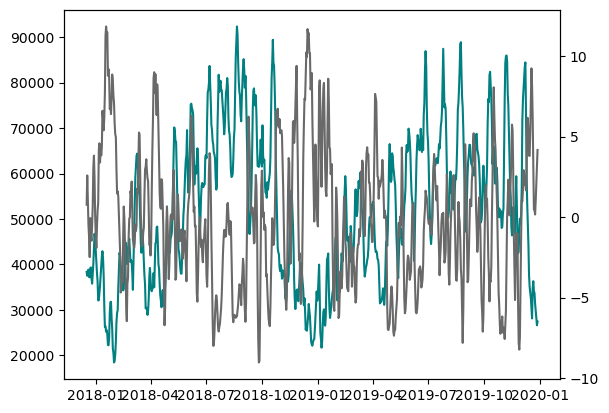

In [181]:
fig,ax = plt.subplots()

ax.plot(haro_bclin,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,winds_haro_bclin,color='dimgrey')

In [182]:
corr,p = stats.spearmanr(winds_haro_bclin,haro_bclin)
print('Winds and transport through Haro:',corr)

corr,p = stats.spearmanr(densdiff_haro_bclin,winds_haro_bclin)
print('Winds and density diff:',corr)

Winds and transport through Haro: -0.41441209425320646
Winds and density diff: -0.5594885106305166


0.09264501032127648


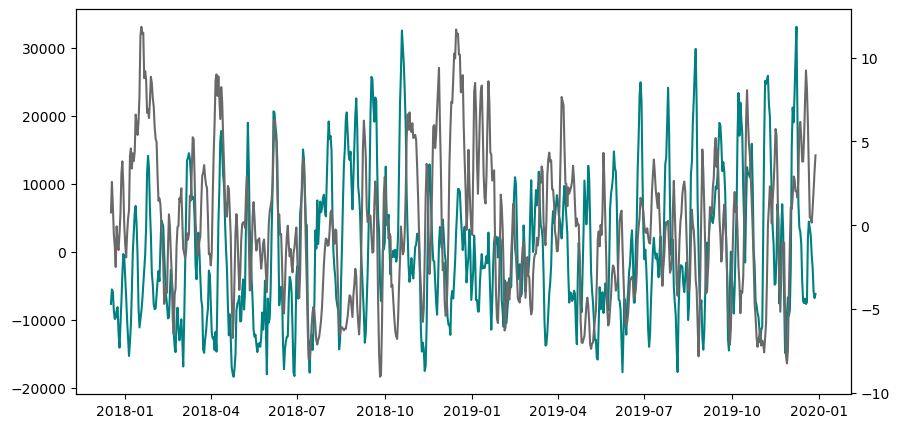

In [183]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,winds_haro_bclin,color='dimgrey')

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_bclin)
print(corr)

Not really a relationship here, look at ssh

-0.10893071339943239


Text(0.5, 1.0, 'Residual baroclinic haro, corr: -0.11')

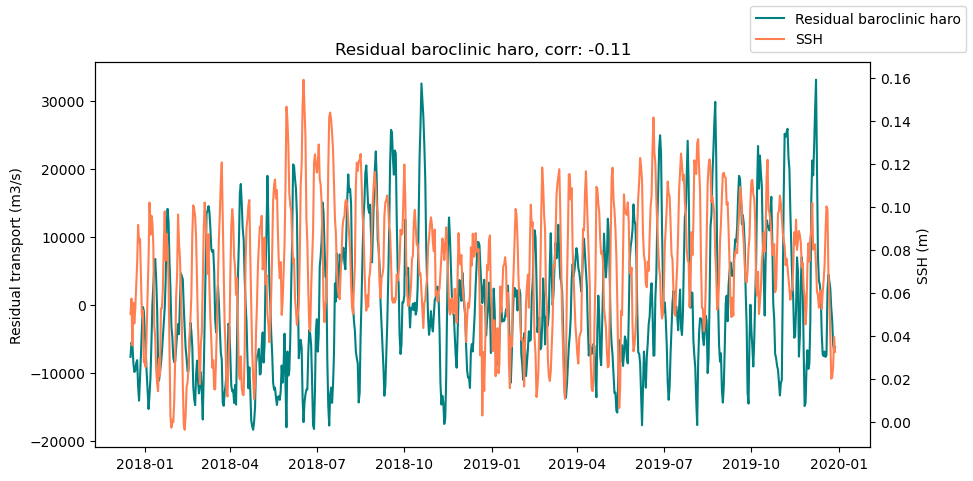

In [184]:
corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,label='Residual baroclinic haro',color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,ssh_haro_bclin,label='SSH',color='coral')
fig.legend()
ax.set_ylabel('Residual transport (m3/s)')
ax2.set_ylabel('SSH (m)')
ax.set_title(f'Residual baroclinic haro, corr: {np.round(corr,2)}')


Slightly more of something but tides + ssh likely have some sort of relationship

Take residual after tides

0.11610446506176399


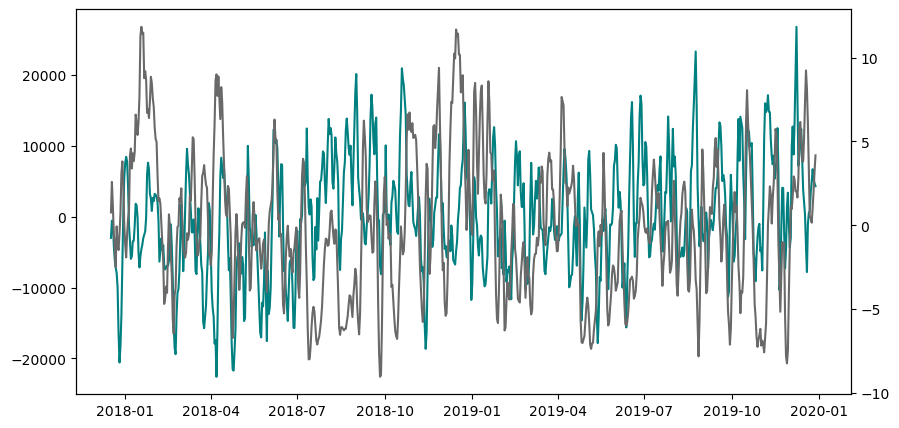

In [185]:
## Remove tides

slope,intercept = np.polyfit(tides_haro_bclin,res_haro_bclin,1)
tideline_haro_bclin = slope*tides_haro_bclin + intercept
res_haro_bclin_tides = res_haro_bclin.values - tideline_haro_bclin

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_bclin_tides)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(date_haro_bclin,res_haro_bclin_tides,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,winds_haro_bclin,color='dimgrey')

-0.018127399855304524


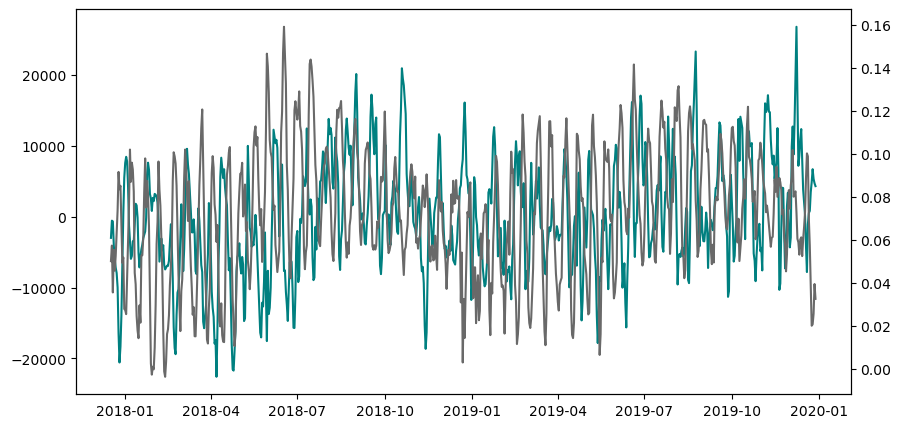

In [186]:
corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_bclin_tides)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(date_haro_bclin,res_haro_bclin_tides,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,ssh_haro_bclin,color='dimgrey')

Nothing here really either --> next, barotropic

#### Haro barotropic

-0.07434073749863225


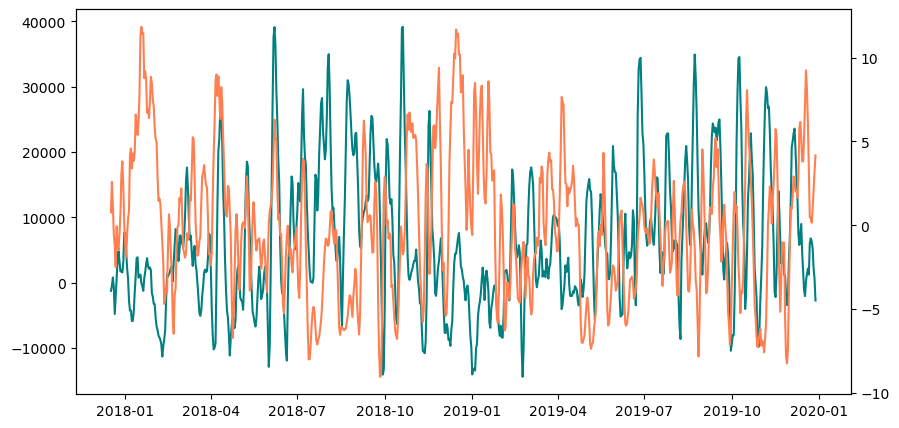

In [187]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(winds_haro_bclin,haro_btrop)
print(corr)

ax.plot(haro_btrop,color='teal',label='Barotropic Haro')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,winds_haro_bclin,color='coral',label='Winds')

-0.047316954764819716


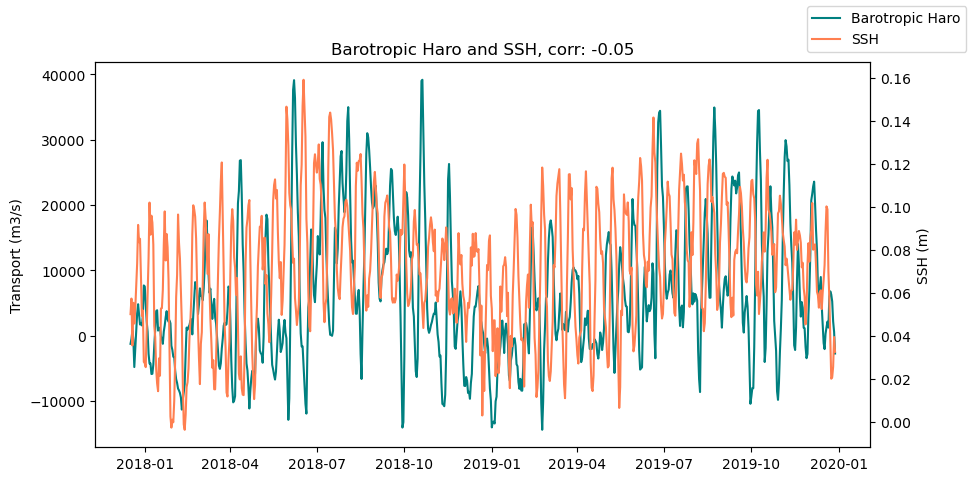

In [188]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(ssh_haro_bclin,haro_btrop)
print(corr)

ax.plot(haro_btrop,color='teal',label='Barotropic Haro')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,ssh_haro_bclin,color='coral',label='SSH')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('SSH (m)')
ax.set_title(f'Barotropic Haro and SSH, corr: {np.round(corr,2)}')
fig.legend()

Nothing, remove tides

0.004277630096895242


Text(0.5, 1.0, 'Barotropic haro residual and SSH, corr:0.0')

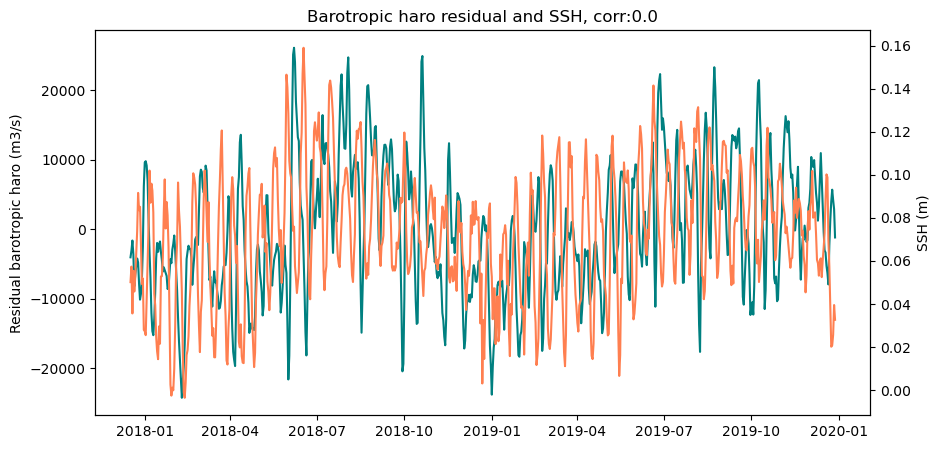

In [189]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_btrop_tides)
print(corr)

ax.plot(date_haro_btrop,res_haro_btrop_tides,color='teal',label='Barotropic haro residual')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,ssh_haro_bclin,color='coral',label='SSH')
ax.set_ylabel('Residual barotropic haro (m3/s)')
ax2.set_ylabel('SSH (m)')
ax.set_title(f'Barotropic haro residual and SSH, corr:{np.round(corr,2)}')

-0.07448563943102177


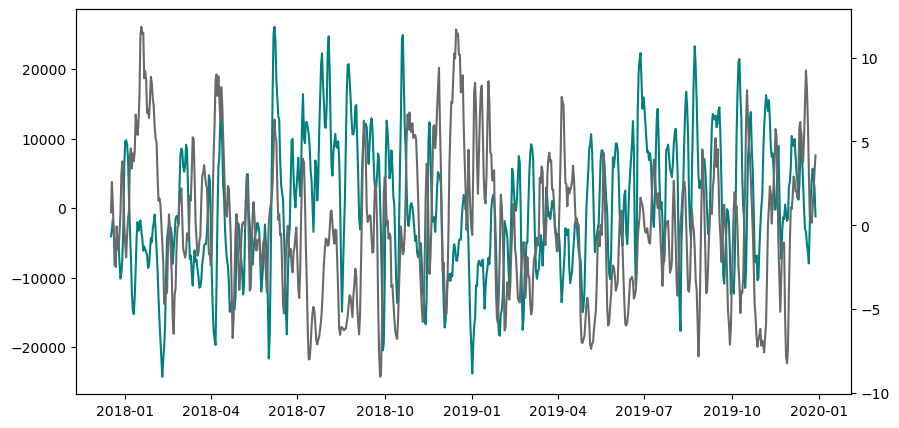

In [190]:
fig,ax = plt.subplots(figsize=(10,5))

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_btrop_tides)
print(corr)

ax.plot(date_haro_btrop,res_haro_btrop_tides,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_btrop,winds_haro_bclin,color='dimgrey')

remove density difference

In [191]:
slope,intercept = np.polyfit(densdiff_haro_btrop,res_haro_btrop_tides,1)
ddline_haro_btrop = slope*densdiff_haro_btrop + intercept
res_haro_btrop_dd = res_haro_btrop_tides - ddline_haro_btrop

corr,p = stats.spearmanr(winds_haro_bclin,res_haro_btrop_dd)
print(corr)

corr,p = stats.spearmanr(ssh_haro_bclin,res_haro_btrop_dd)
print(corr)

0.15997556752273734
-0.14801609995254486


This means nothing because winds and ssh are strongly positively correlated (0.96)

Summary:
- Density difference and tides make up most of variation for baroclinic through Haro
- Other variables pretty insignficant
- Correlation b/w tides and barotropic through Haro, then small correlation with DD (nothing with other variables)

### Fraser River discharge

In [192]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge.csv')
FR_4mean = FR_data['Discharge (m3/s)'].rolling(window=4,center=True).mean()

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_FR = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_FR.append(date)
    date += dt.timedelta(days=1)

0.49787471302932124


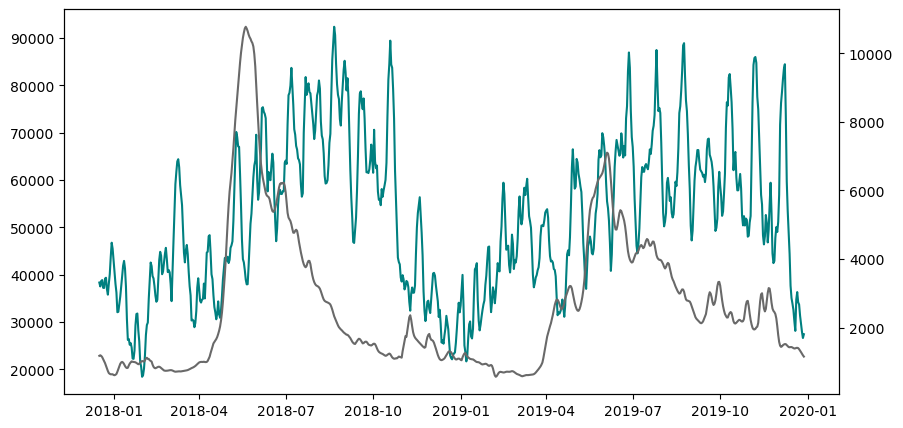

In [193]:
mask = np.isin(datelist_FR,date_haro_bclin)
FR_haro_bclin = FR_4mean[mask]

corr,p = stats.spearmanr(FR_haro_bclin,haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_bclin,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,FR_haro_bclin,color='dimgrey')

0.2043245055586339


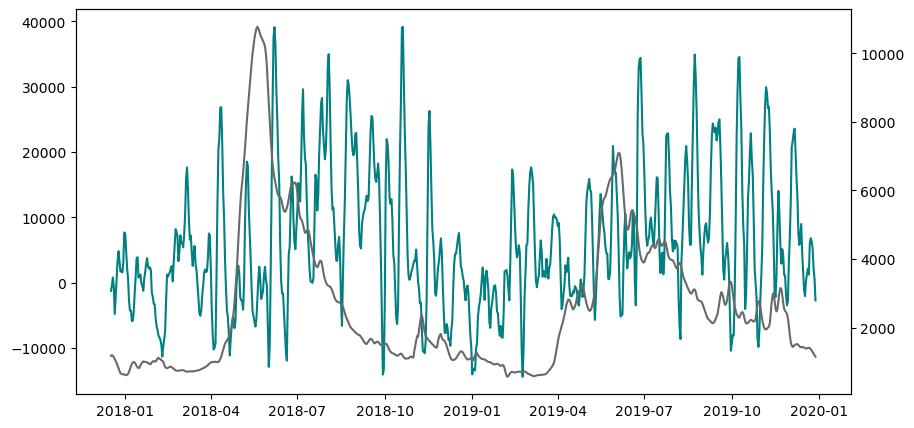

In [194]:
corr,p = stats.spearmanr(FR_haro_bclin,haro_btrop)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(haro_btrop,color='teal')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,FR_haro_bclin,color='dimgrey')

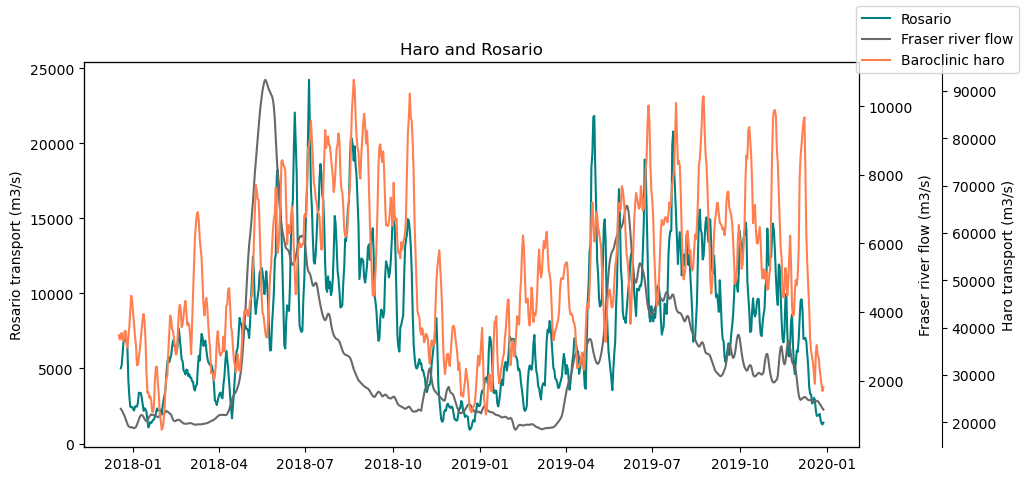

In [195]:
# Rosario and FR
mask = np.isin(datelist_FR,date_rossh)
FR_ros = FR_4mean[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth.dropna(),color='teal',label='Rosario')
ax2 = ax.twinx()
ax2.plot(date_rossh,FR_ros,color='dimgrey',label='Fraser river flow')
ax3 = ax.twinx()
ax3.plot(haro_bclin,color='coral',label='Baroclinic haro')
ax.set_title('Haro and Rosario')
ax.set_ylabel('Rosario transport (m3/s)')
ax2.set_ylabel('Fraser river flow (m3/s)')
ax3.set_ylabel('Haro transport (m3/s)')
ax3.spines['right'].set_position(('outward', 60))
fig.legend()

Text(0.5, 1.0, 'Haro')

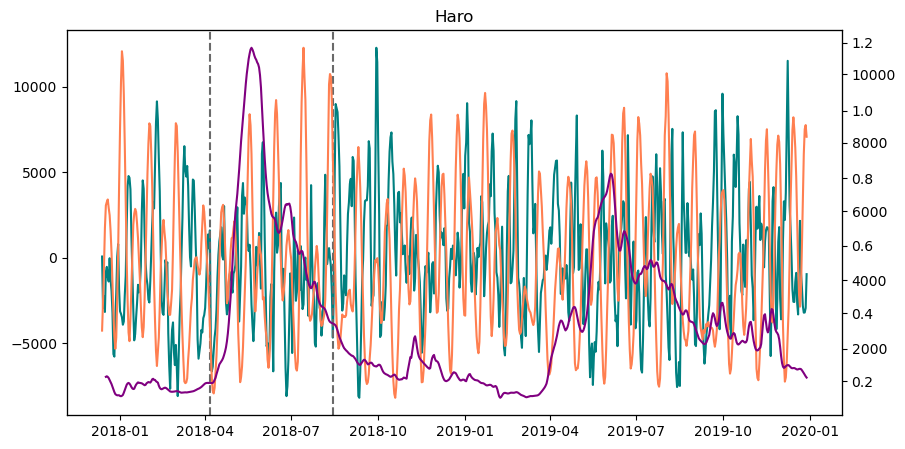

In [196]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro2,color='teal')
ax2 = ax.twinx()
ax2.plot(date_harosh,tides_haro_sh,color='coral')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,FR_haro_bclin,color='purple')
ax.axvline(date_haro_bclin[110],color='dimgrey',ls='--')
ax.axvline(date_haro_bclin[240],color='dimgrey',ls='--')
ax.set_title('Haro')

Seems to be the same time period where Fraser River discharge is higher but starts a little earlier? Look at all rivers and see if its different

Also look @ if its diff for flow to adm vs. vicsill (Rosario)

Look with 4 day mean of rostosouth

### All runoff (add climatology for other rivers)

In [197]:
rivers = xr.open_dataset('/data/SalishSeaCast/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
clim = np.zeros(365)

for river in rivers.data_vars:
    clim += rivers[river][0:]
    
clim -= rivers['fraser']

In [198]:
date = dt.datetime(2020,1,1)
enddate = dt.datetime(2020,12,31)
dates = []
datelist_2020 = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_2020.append(date)
    date += dt.timedelta(days=1)

idx_leap = datelist_2020.index(dt.datetime(2020,2,29))

clim2020 = np.insert(clim,idx_leap,(clim[58]+clim[59])/2)

clim1718 = np.append(clim,clim)
clim1719 = np.append(clim1718,clim)
clim1720 = np.append(clim1719,clim2020)
clim1721 = np.append(clim1720,clim)
clim1722 = np.append(clim1721,clim)
len(clim1722)

2191

In [199]:
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_yrs = []
dates = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yrs.append(date)
    date += dt.timedelta(days=1)
       
df_FR_4mean = pd.DataFrame(FR_4mean.values,index=datelist_FR)
df_clim = pd.DataFrame(clim1722,index=datelist_yrs)

runoff = df_FR_4mean.add(df_clim, fill_value=0)

0.1508481024866328


Text(0.5, 1.0, 'Haro')

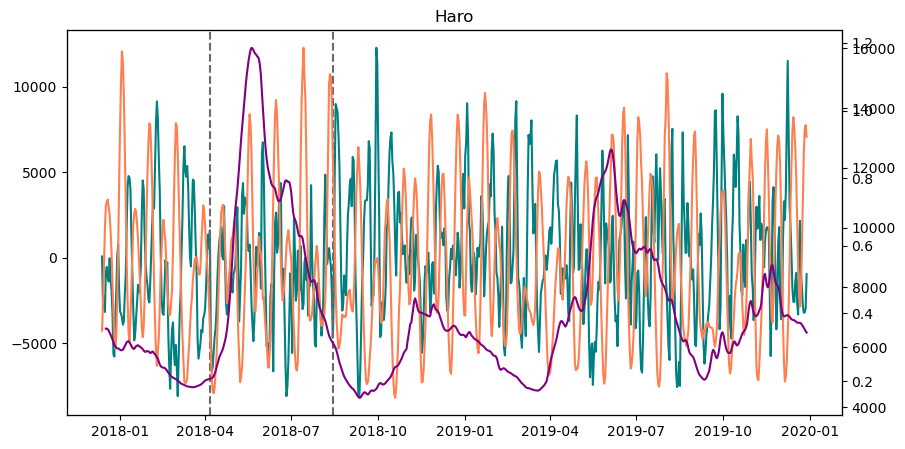

In [200]:
mask = np.isin(datelist_yrs,date_haro_bclin)
runoff_haro_bclin = runoff[0].values[mask]

corr,p = stats.spearmanr(runoff_haro_bclin,haro_bclin)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro2,color='teal')
ax2 = ax.twinx()
ax2.plot(date_harosh,tides_haro_sh,color='coral')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,runoff_haro_bclin,color='purple')
ax.axvline(date_haro_bclin[110],color='dimgrey',ls='--')
ax.axvline(date_haro_bclin[240],color='dimgrey',ls='--')
ax.set_title('Haro')

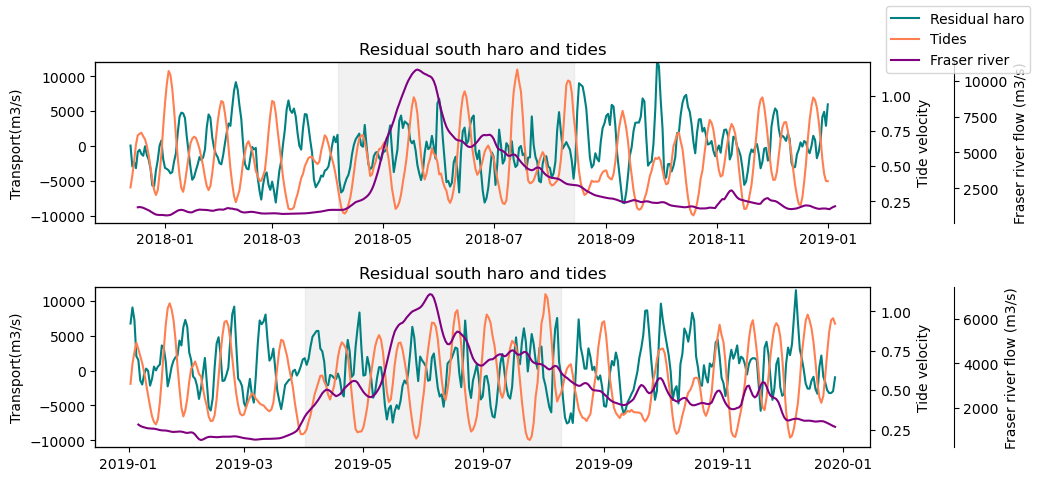

In [206]:
fig,[ax,ax4] = plt.subplots(2,1,figsize=(10,5))

ax.plot(res_haro2[0:385],color='teal',label='Residual haro')
ax2 = ax.twinx()
ax2.plot(date_harosh[0:385],tides_haro_sh[0:385],color='coral',label='Tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin[0:385],FR_haro_bclin[0:385],color='purple',label='Fraser river')
ax.set_title('Residual south haro and tides')
ax.set_ylabel('Transport(m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow (m3/s)')
ax.set_ylim([-11000,12000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_bclin[110],x2=date_haro_bclin[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
fig.legend()

ax4.plot(res_haro2[385:],color='teal',label='Residual haro')
ax42 = ax4.twinx()
ax42.plot(date_harosh[385:],tides_haro_sh[385:],color='coral',label='Tides')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_haro_bclin[385:],FR_haro_bclin[385:],color='purple',label='Fraser river')
ax4.set_title('Residual south haro and tides')
ax4.set_ylabel('Transport(m3/s)')
ax42.set_ylabel('Tide velocity')
ax43.set_ylabel('Fraser river flow (m3/s)')
ax4.set_ylim([-11000,12000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_haro_bclin[470],x2=date_haro_bclin[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))

fig.subplots_adjust(hspace=0.4)

Look at what happens in Rosario in little november spike

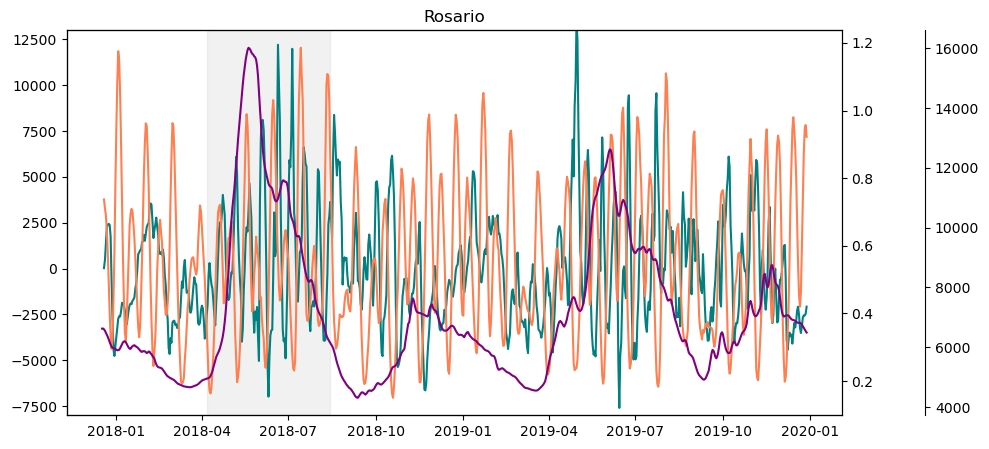

In [207]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res,color='teal')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='coral')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,runoff_haro_bclin,color='purple')
ax.set_title('Rosario')
ax.set_ylim([-8000,13000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_bclin[110],x2=date_haro_bclin[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))

Text(0, 0.5, 'Fraser river flow (m3/s)')

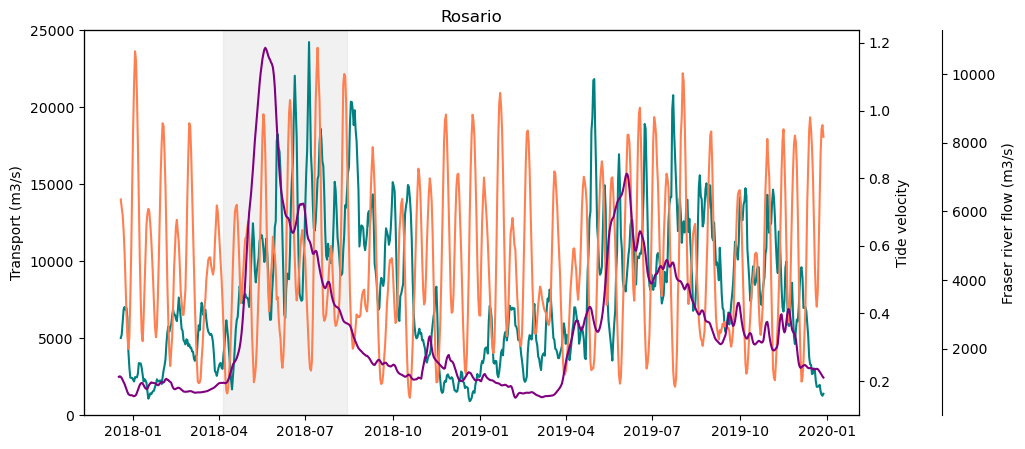

In [208]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth.dropna(),color='teal',label='Rosario flow')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='coral',label='Tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,FR_haro_bclin,color='purple',label='river flow')
ax.set_title('Rosario')
ax.set_ylim([0,25000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_bclin[110],x2=date_haro_bclin[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow (m3/s)')

Text(0, 0.5, 'River flow (m3/s)')

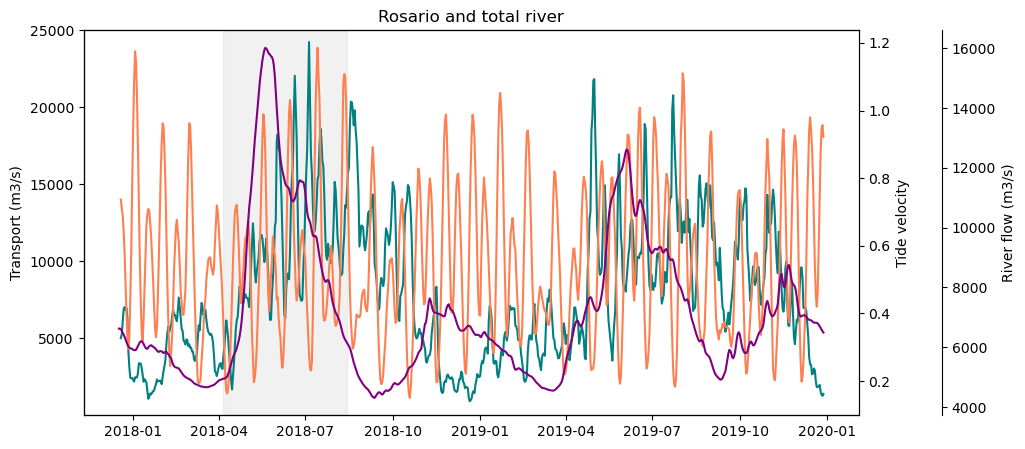

In [209]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth.dropna(),color='teal',label='Rosario flow')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='coral',label='Tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,runoff_haro_bclin,color='purple',label='river flow')
ax.set_title('Rosario and total river')
ax.set_ylim([8,25000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_bclin[110],x2=date_haro_bclin[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('River flow (m3/s)')

In [ ]:
stats.spearmanr(tides_sh[110:240],rostosouth.dropna()[110:240])

SignificanceResult(statistic=0.3898592087834054, pvalue=4.541967294097993e-06)

#### Look at timing of shift with ssh, see if its because of long-term winds

In [214]:
mask = np.isin(datelist_ssh,date_haro_bclin)
ssh_vs_haro_bclin = ssh_vicsill[mask]
ssh_jdf_haro_bclin = ssh_jdf[mask]
ssh_jdf7_haro_bclin = ssh_jdf7[mask]

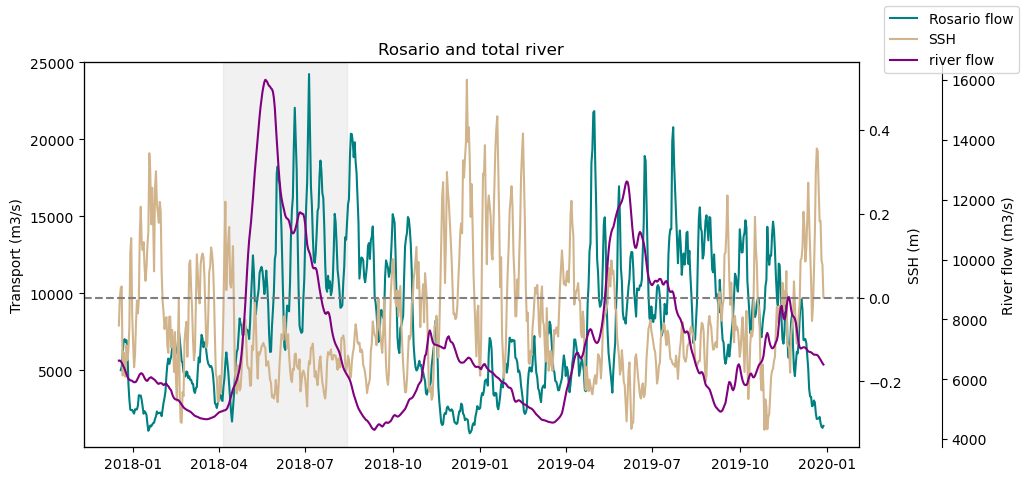

In [215]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(rostosouth.dropna(),color='teal',label='Rosario flow')
ax2 = ax.twinx()
ax2.plot(date_haro_bclin,ssh_jdf_haro_bclin,color='tan',label='SSH')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_haro_bclin,runoff_haro_bclin,color='purple',label='river flow')
ax.set_title('Rosario and total river')
ax.set_ylim([8,25000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_haro_bclin[110],x2=date_haro_bclin[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('SSH (m)')
ax3.set_ylabel('River flow (m3/s)')
fig.legend()
ax2.axhline(y=0,color='grey',ls='--')